In [2]:
library(tidyverse)
library(rdmc)
library(vroom)
library(cowplot)
theme_set(cowplot::theme_cowplot())
library(patchwork)
library(ggraph)

options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
source("../color_df.R")
color_df <-
    color_df %>% 
    mutate(
        ssp_pop = pop,
        pop = str_remove_all(ssp_pop, "(LR_|Teo_|random1_|random2_)")
    ) %>% 
    dplyr::select(-ssp_pop) %>% 
    distinct()
color_df

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: rlang


Attaching package: ‘rlang’


The following object is masked from ‘package:magrittr’:

    set_names


The following o

pop,color
<chr>,<chr>
Los_Guajes,mediumaquamarine
Crucero_Lagunitas,gold
El_Rodeo,darkorange
Amatlan_de_Canas,cornflowerblue
San_Lorenzo,purple
Palmar_Chico,violetred
random,grey


Rows: 1,036,881
Columns: 2
Delimiter: "\t"
dbl [2]: pos, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,322
Columns: 4
Delimiter: "\t"
chr [1]: chrom
dbl [3]: start, end, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,466,646
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: start, pos, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message:
“Removed 1435593 rows containing missing values (geom_point).”
Rows: 1,466,646
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: start, pos, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message:
“Removed 16224 rows containing missing 

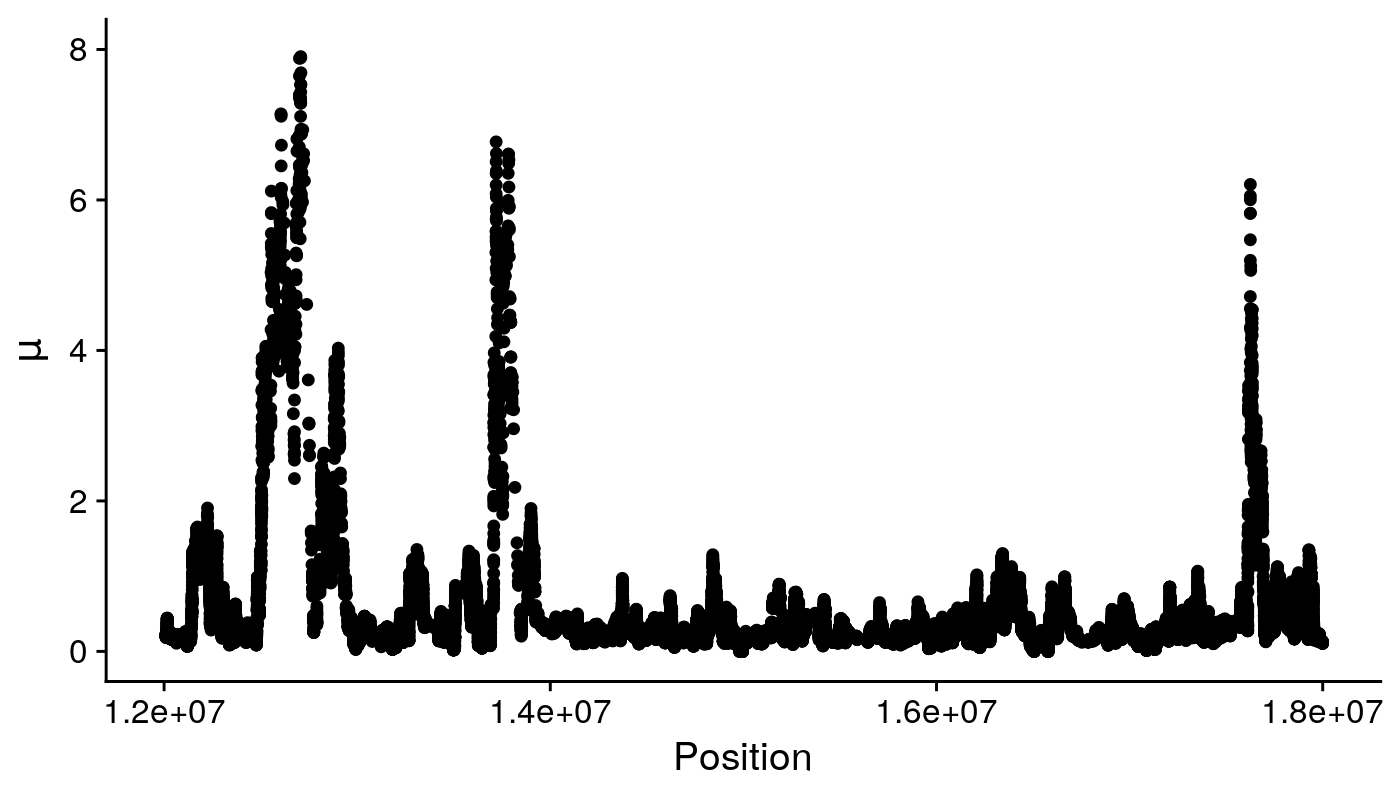

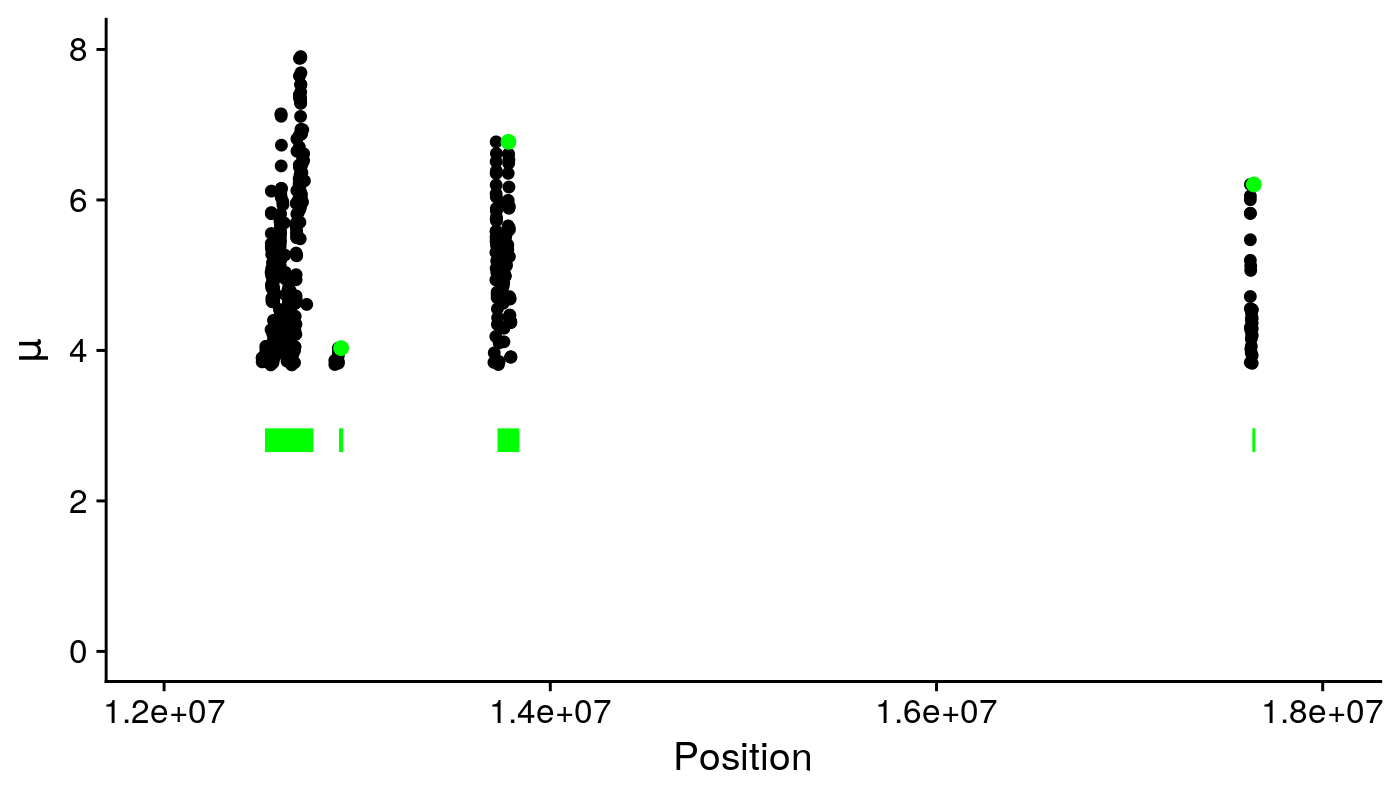

In [2]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)


raisd_sim <- vroom("../data/mushi/RAiSD_Report.v5--LR--random1_Palmar_Chico--msprime", "\t", skip = 1, col_names = c("pos", "mu"))
q <- quantile(raisd_sim$mu, 0.99, na.rm = TRUE)

blocks <- vroom("../data/raisd/v5--LR--random1_Palmar_Chico.corrected_block_outliers_merged.txt", delim = "\t", 
                col_names = c("chrom", "start", "end", "mu")) %>% 
                filter(chrom == "chr3", mu > q)



outlier_df_L <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr3--0--238017767.corrected", delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu")) %>%
    filter(mu > 0)



ggplot() +
    geom_point(data = outlier_df_L, mapping = aes(pos, mu)) +
    ylab(expression(mu)) +
    xlim(1.2e7, 1.8e7) +
    ylim(0, 8) +
    xlab("Position")


outlier_df <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr3--0--238017767.corrected", delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu")) %>%
    filter(mu > q)


ggplot() +
    geom_point(data = outlier_df, mapping = aes(pos, mu)) +
    geom_point(data = blocks, mapping = aes((start + end)/2, mu), size = 2, colour = "green") +
    geom_segment(data = blocks, mapping = aes(x = start, xend = end, y = q-1, yend = q-1), lwd = 4, colour = "green") +
    ylab(expression(mu)) +
    xlim(1.2e7, 1.8e7) +
    ylim(0, 8) +
    xlab("Position")
    

In [3]:
#raisd <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr10--0--152435371.txt", delim = "\t", skip = 1, 
#              col_names = c("pos", "start", "end", "var", "sfs", "ld", "mu")) %>% 
#              mutate(chrom = "chr10")    

raisd <- vroom("../data/raisd/RAiSD_Report.v5--Teo--Amatlan_de_Canas--chr2--0--243675191.txt", delim = "\t", skip = 1,
                 col_names = c("pos", "start", "end", "var", "sfs", "ld", "mu"))

raisd_c <- vroom("../data/raisd/RAiSD_Report.v5--Teo--Amatlan_de_Canas--chr2--0--243675191.corrected", delim = "\t", 
                 col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu"))%>% 
                dplyr::select(-start, -end)


raisd_j <- full_join(raisd, raisd_c, by = c("pos"), suffix = c("_raw", "_corrected")) %>% drop_na()


Rows: 1,530,509
Columns: 7
Delimiter: "\t"
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 1,530,509
Columns: 8
Delimiter: "\t"
chr [1]: chrom
dbl [7]: pos, start, end, var, sfs, ld, mu

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



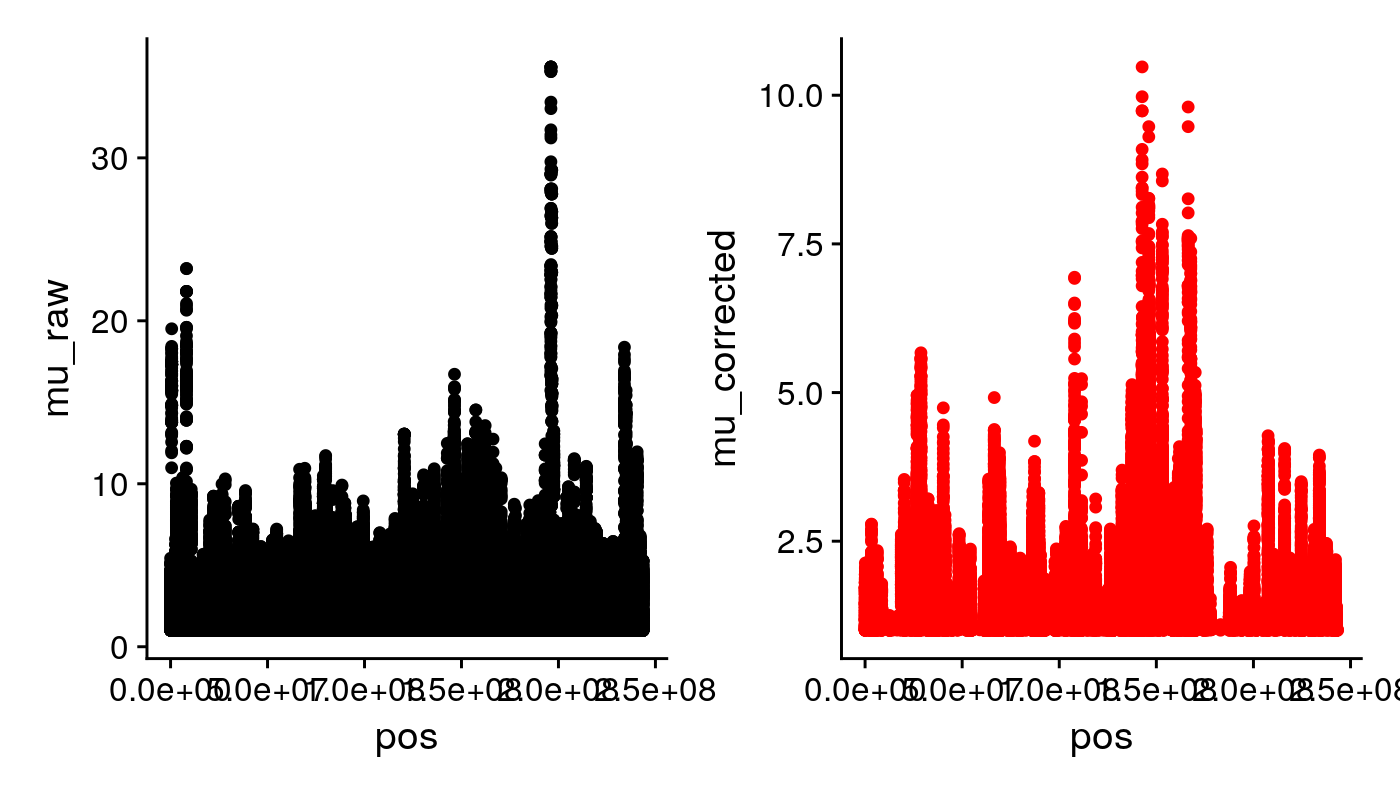

In [4]:
neutral <- 1
a <- ggplot() + geom_point(data = filter(raisd_j, mu_raw > neutral), mapping = aes(pos, mu_raw))
b <- ggplot() + geom_point(data = filter(raisd_j, mu_corrected > neutral), mapping = aes(pos, mu_corrected), colour = "red")

a + b 

In [5]:
head(raisd)

pos,start,end,var,sfs,ld,mu
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16524,2866,30181,1.716,0.8869,1.727,2.629
16605,2973,30237,1.713,0.9224,1.719,2.716
17019,3048,30989,1.755,0.8869,1.848,2.877
17474,3049,31898,1.812,0.8869,1.868,3.002
17565,3085,32045,1.819,0.8869,1.988,3.207
17695,3123,32267,1.831,0.8869,2.027,3.292



	Pearson's product-moment correlation

data:  raisd_j$mu_raw and raisd_j$mu_corrected
t = 670.63, df = 1530507, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4753409 0.4777898
sample estimates:
      cor 
0.4765663 


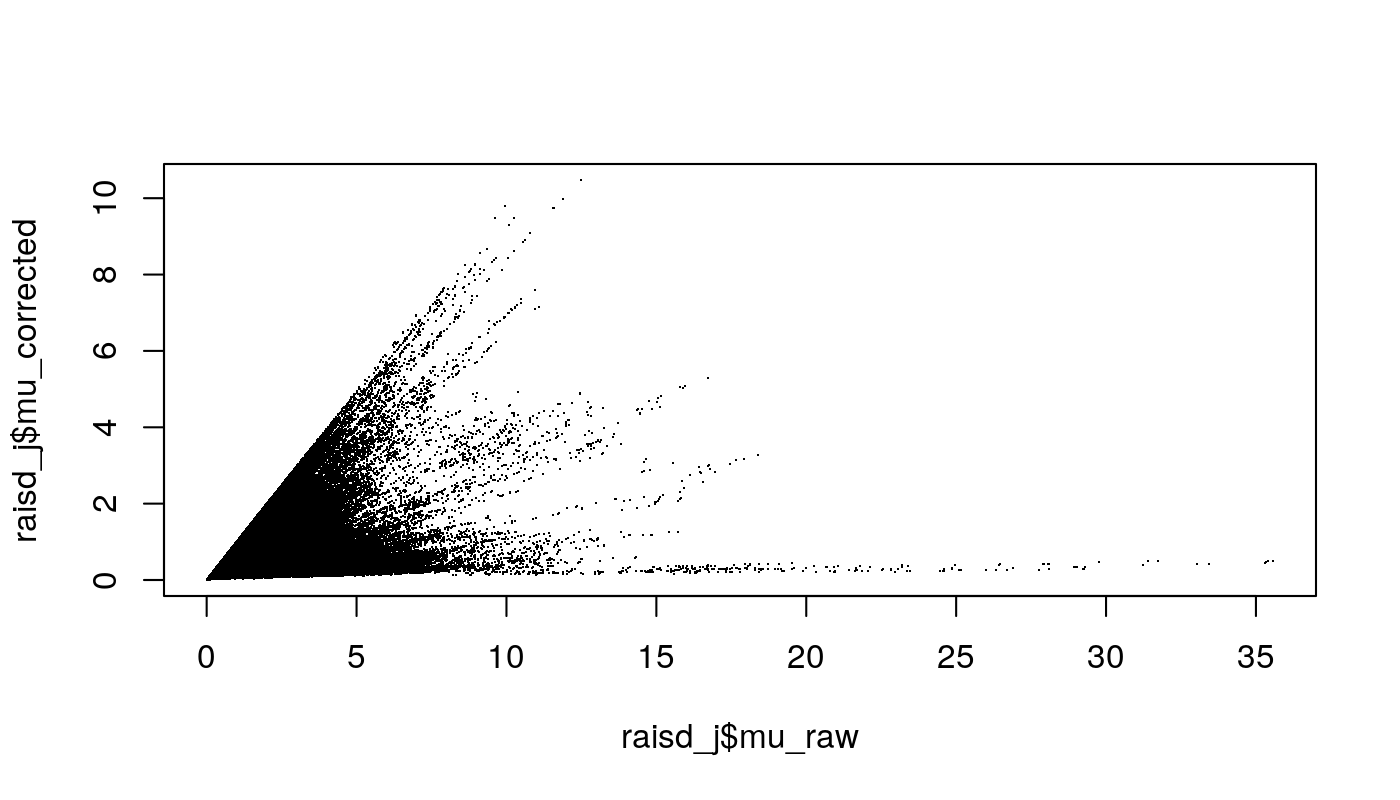

In [6]:
plot(raisd_j$mu_raw, raisd_j$mu_corrected, pch = ".")
cor.test(raisd_j$mu_raw, raisd_j$mu_corrected, method = "pe")

# Sharing

In [16]:

all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--RANDOM1_Palmar_Chico", 
    "v5--LR--RANDOM2_Palmar_Chico", 
    "v5--LR--random", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--RANDOM1_Palmar_Chico", 
    "v5--Teo--RANDOM2_Palmar_Chico", 
    "v5--Teo--random", 
    "v5--Teo--San_Lorenzo"
)

pop_pairs <- 
combn(all_pops, 2) %>% 
    t() %>% 
    data.frame() %>% 
    set_colnames(c("pop1", "pop2")) %>% 
    as_tibble() %>% 
    mutate(pop1 = str_replace_all(pop1, "random1", "RANDOM1"),
           pop2 = str_replace_all(pop2, "random2", "RANDOM2"))
head(pop_pairs)


pop1,pop2
<chr>,<chr>
v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas
v5--LR--Amatlan_de_Canas,v5--LR--Los_Guajes
v5--LR--Amatlan_de_Canas,v5--LR--RANDOM1_Palmar_Chico
v5--LR--Amatlan_de_Canas,v5--LR--RANDOM2_Palmar_Chico
v5--LR--Amatlan_de_Canas,v5--LR--random
v5--LR--Amatlan_de_Canas,v5--LR--San_Lorenzo


Rows: 4,466
Columns: 5
Delimiter: "\t"
chr [2]: chrom, populations
dbl [3]: start, end, size

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



,type,total_sweeps
,<chr>,<int>
1,both,4149
2,Landraces,2543
3,Teosinte,1078


chrom,start,end,size,populations,type,pop_count,Landraces_count,Teosinte_count
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>
chr1,17196,867050,849854,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,v5--LR--random,v5--LR--RANDOM1_Palmar_Chico,v5--LR--RANDOM2_Palmar_Chico,v5--Teo--Amatlan_de_Canas,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--San_Lorenzo,v5--Teo--random,v5--Teo--RANDOM1_Palmar_Chico,v5--Teo--RANDOM2_Palmar_Chico",both,15,7,8
chr1,995115,1294915,299800,"v5--LR--Los_Guajes,v5--LR--San_Lorenzo,v5--LR--RANDOM1_Palmar_Chico,v5--LR--RANDOM2_Palmar_Chico,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--RANDOM1_Palmar_Chico,v5--Teo--RANDOM2_Palmar_Chico",both,9,4,5
chr1,1416327,1694646,278319,"v5--LR--Amatlan_de_Canas,v5--LR--San_Lorenzo,v5--LR--RANDOM1_Palmar_Chico,v5--LR--RANDOM2_Palmar_Chico,v5--Teo--Amatlan_de_Canas,v5--Teo--Crucero_Lagunitas,v5--Teo--El_Rodeo,v5--Teo--Los_Guajes,v5--Teo--random,v5--Teo--RANDOM1_Palmar_Chico,v5--Teo--RANDOM2_Palmar_Chico",both,11,4,7
chr1,2150620,2231829,81209,"v5--LR--Amatlan_de_Canas,v5--LR--San_Lorenzo,v5--Teo--RANDOM1_Palmar_Chico",both,3,2,1
chr1,3528178,3531358,3180,v5--Teo--San_Lorenzo,Teosinte,1,0,1
chr1,3584422,3643894,59472,"v5--LR--Los_Guajes,v5--LR--San_Lorenzo",Landraces,2,2,0
chr1,4229809,4239026,9217,v5--Teo--RANDOM1_Palmar_Chico,Teosinte,1,0,1
chr1,4802567,4811575,9008,v5--Teo--RANDOM2_Palmar_Chico,Teosinte,1,0,1
chr1,4929927,5011327,81400,"v5--LR--Amatlan_de_Canas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo",Landraces,3,3,0


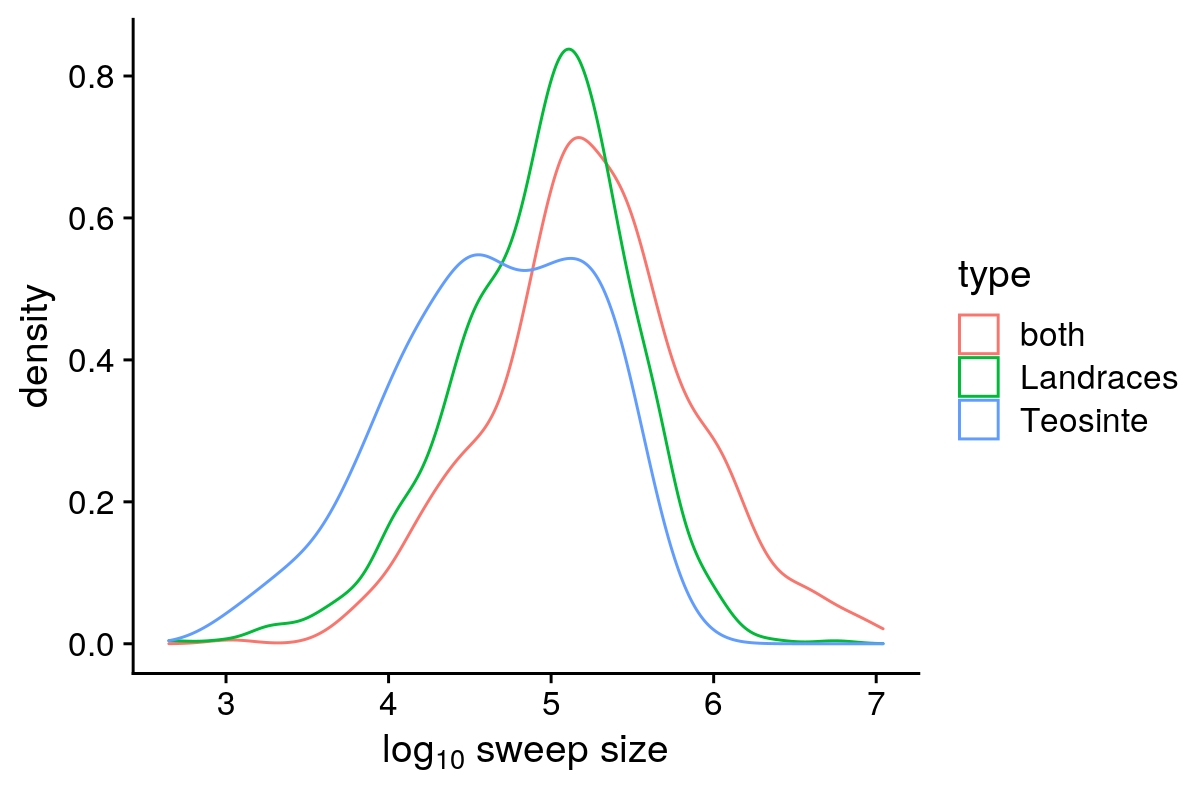

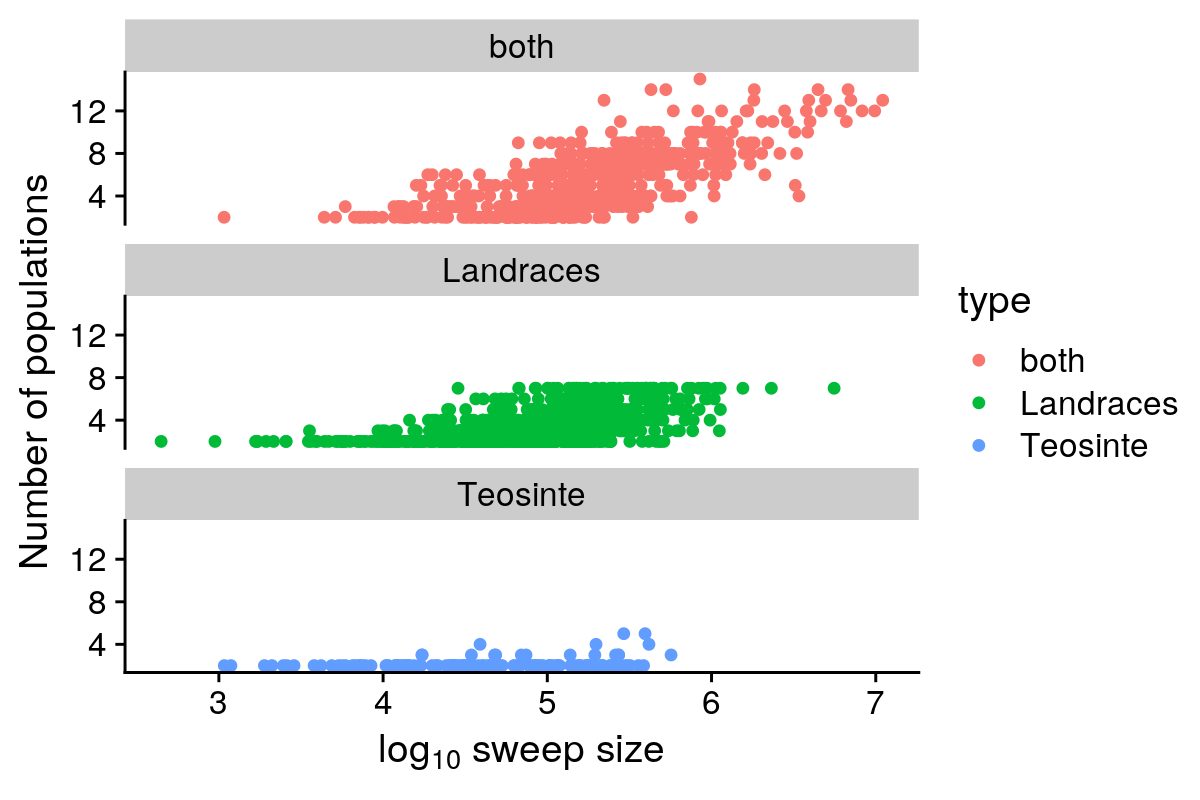

In [65]:
options(repr.plot.width = 6, repr.plot.height =4, repr.plot.res = 200)


share_df <- vroom::vroom("../data/raisd/v5--allpops--shared_outliers.txt", 
             col_names = c("chrom", "start", "end", "size", "populations")) %>% 
    mutate(populations = str_remove_all(populations, "(data/raisd/|.corrected_block_outliers_merged.txt)"),
           populations = str_replace_all(populations, "random1", "RANDOM1"),
           populations = str_replace_all(populations, "random2", "RANDOM2"),
           type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan"
    ),
        pop_count = str_count(populations, ",")+1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(size > 1)

sweep_counts_df <- share_df %>% 
    group_by(type) %>%
    summarise(total_sweeps = n()) %>%
    ungroup() %>% 
    mutate(total_sweeps = ifelse(type == "both", sum(.$total_sweeps), total_sweeps))

    sweep_counts_df

share_df

share_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(size), colour = type)) +
    geom_density() +
    xlab(expression(paste(log[10], " sweep size")))


share_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(size), pop_count, colour = type)) +
    geom_point() +
    facet_wrap(~type, ncol = 1) +
    xlab(expression(paste(log[10], " sweep size"))) +
    ylab("Number of populations")

`summarise()` has grouped output by 'Landraces_count'. You can override using the `.groups` argument.



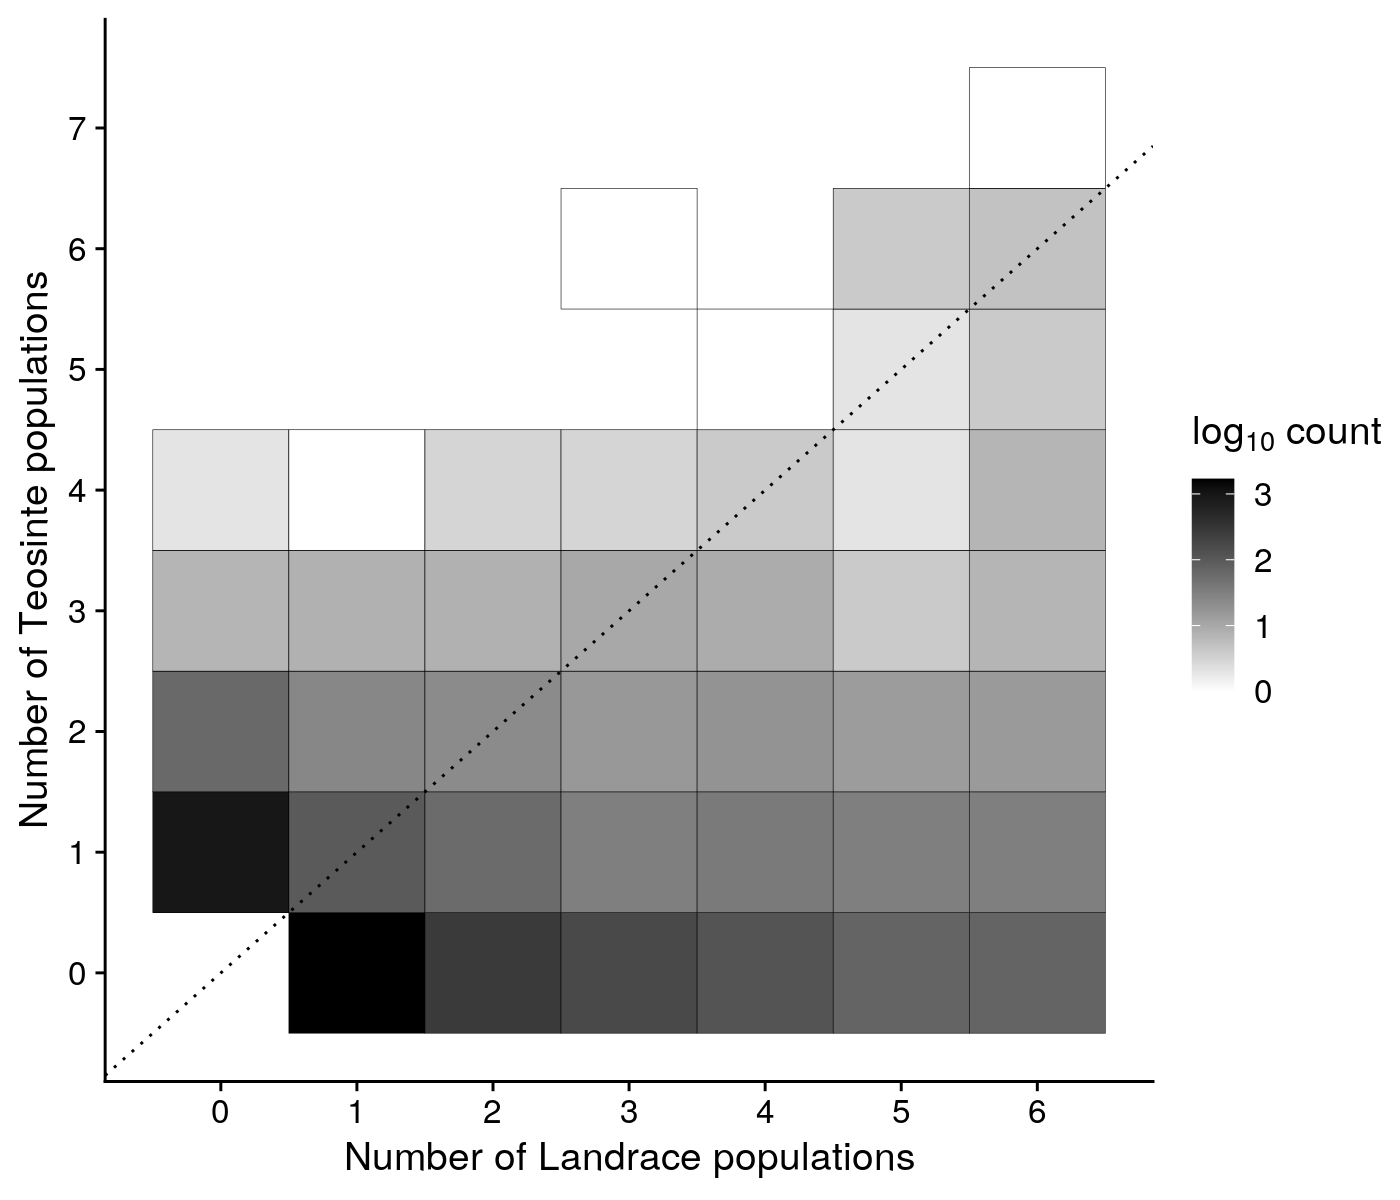

In [66]:
options(repr.plot.width = 7, repr.plot.height = 6 , repr.plot.res = 200)


shareplot <- share_df %>%
    mutate(
        populations = str_remove_all(populations, "(LR--RANDOM2_Palmar_Chico|Teo--RANDOM2_Palmar_Chico)"),
        pop_count = str_count(populations, ",")+1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(Landraces_count != 0 | Teosinte_count != 0) %>%
    group_by(Landraces_count, Teosinte_count) %>% 
    summarise(type_count = n()) %>% 
    ggplot(aes(Landraces_count, Teosinte_count, fill = log10(type_count))) +
    geom_tile(color = "black") +
    scale_fill_gradient(low = "white", high = "black") +
    scale_y_continuous(breaks = 0:8) +
    scale_x_continuous(breaks = 0:8) +
    geom_abline(intercept = 0, slope = 1, lty = 3) +
    xlab("Number of Landrace populations") +
    ylab("Number of Teosinte populations") +
    labs(fill = expression(paste(log[10], " count")))
    
shareplot

Joining, by = "populations"



[1] 0.1876676 0.5742972


Call:
glm(formula = cbind(unique_sweep, total) ~ ssp, family = binomial, 
    data = unique_plot_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-5.014  -2.309  -1.326   1.428   8.373  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.52657    0.02620 -58.261   <2e-16 ***
sspTeo       0.28205    0.04535   6.219    5e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 188.03  on 14  degrees of freedom
Residual deviance: 150.05  on 13  degrees of freedom
AIC: 253.37

Number of Fisher Scoring iterations: 4


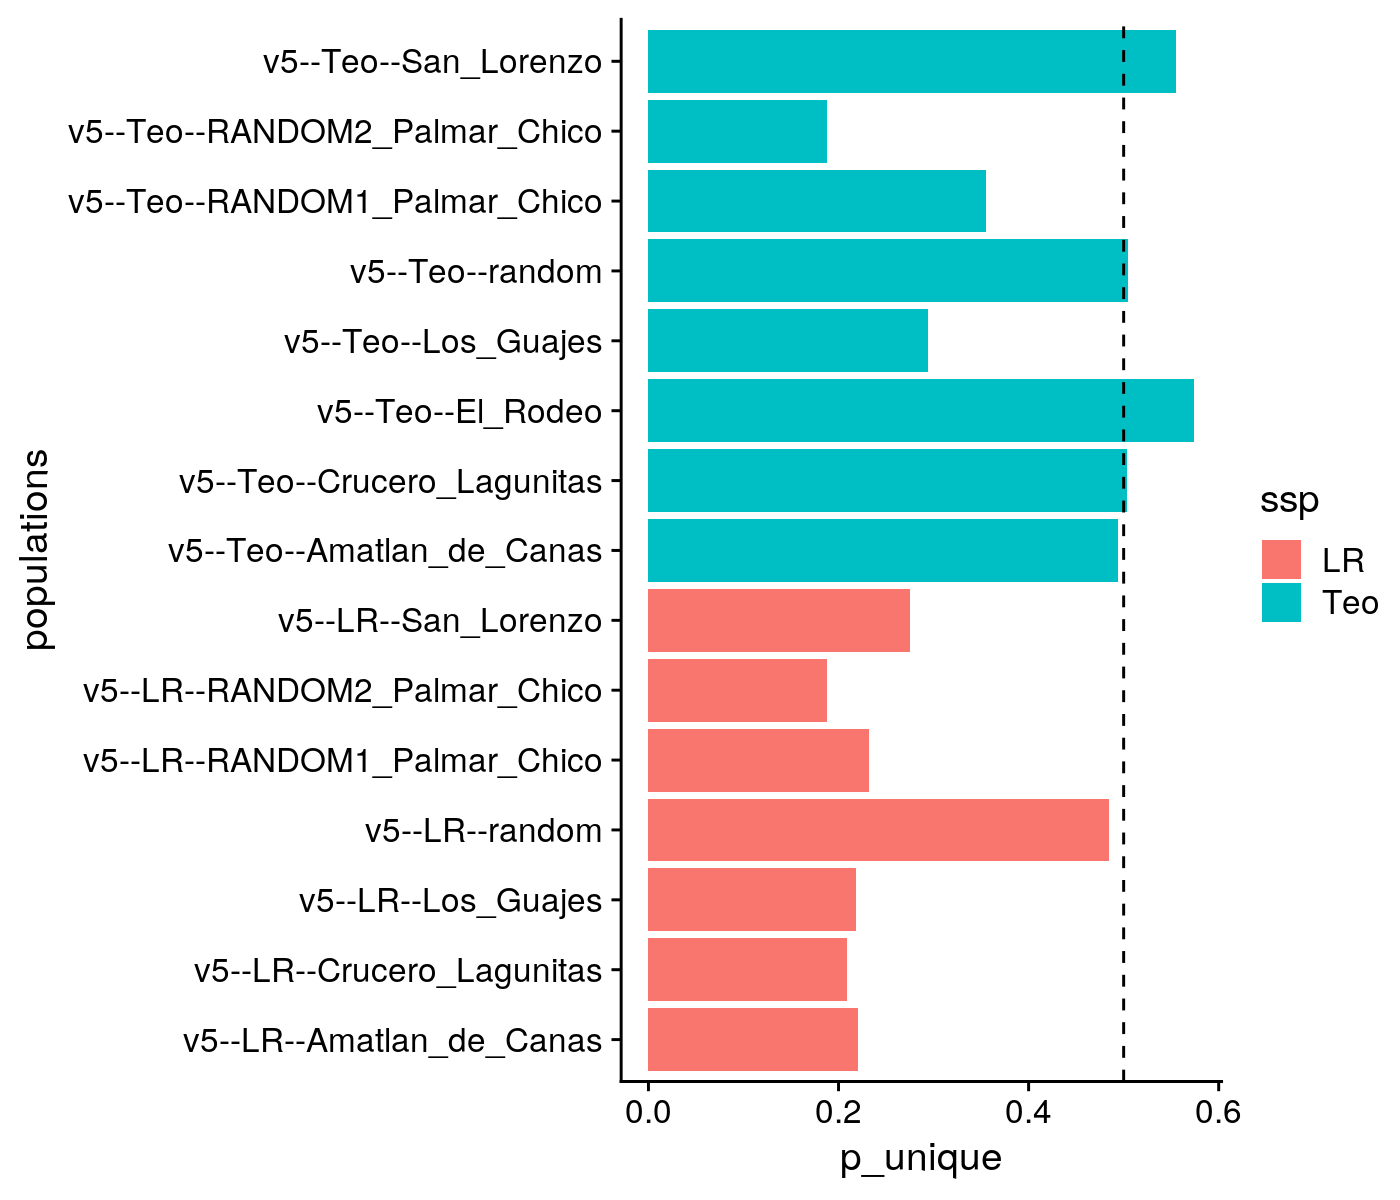

In [100]:
unique_sweep_df <- full_join(
    all_pops %>% 
    map_df(~{
        shared_sweep <- length(grep(.x,  share_df$populations))
        tibble(populations = .x, shared_sweep)
        }),
    share_df %>% 
        filter(pop_count  == 1) %>% 
        group_by(populations) %>% 
        summarise(unique_sweep = n())
) %>% 
    mutate(p_unique = unique_sweep/shared_sweep)

range(unique_sweep_df$p_unique)


pop_order <- arrange(unique_sweep_df, p_unique) %>% pull(populations)
unique_plot_df <- 
unique_sweep_df %>% 
    mutate(
           #populations = factor(populations, level = pop_order),
           pop = populations,
           total = shared_sweep + unique_sweep
    ) %>%
    separate(pop, c("ref", "ssp", "pop"), "--")

unique_plot_df %>% 
    ggplot(aes(populations, p_unique, fill = ssp)) +
    geom_bar(stat = "identity") +
    geom_hline(yintercept = 0.5, lty = 2) +
    coord_flip()

summary(glm(cbind(unique_sweep, total) ~ ssp, data = unique_plot_df, family = binomial))

Rows: 1,000,000
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message:
“Setting row names on a tibble is deprecated.”


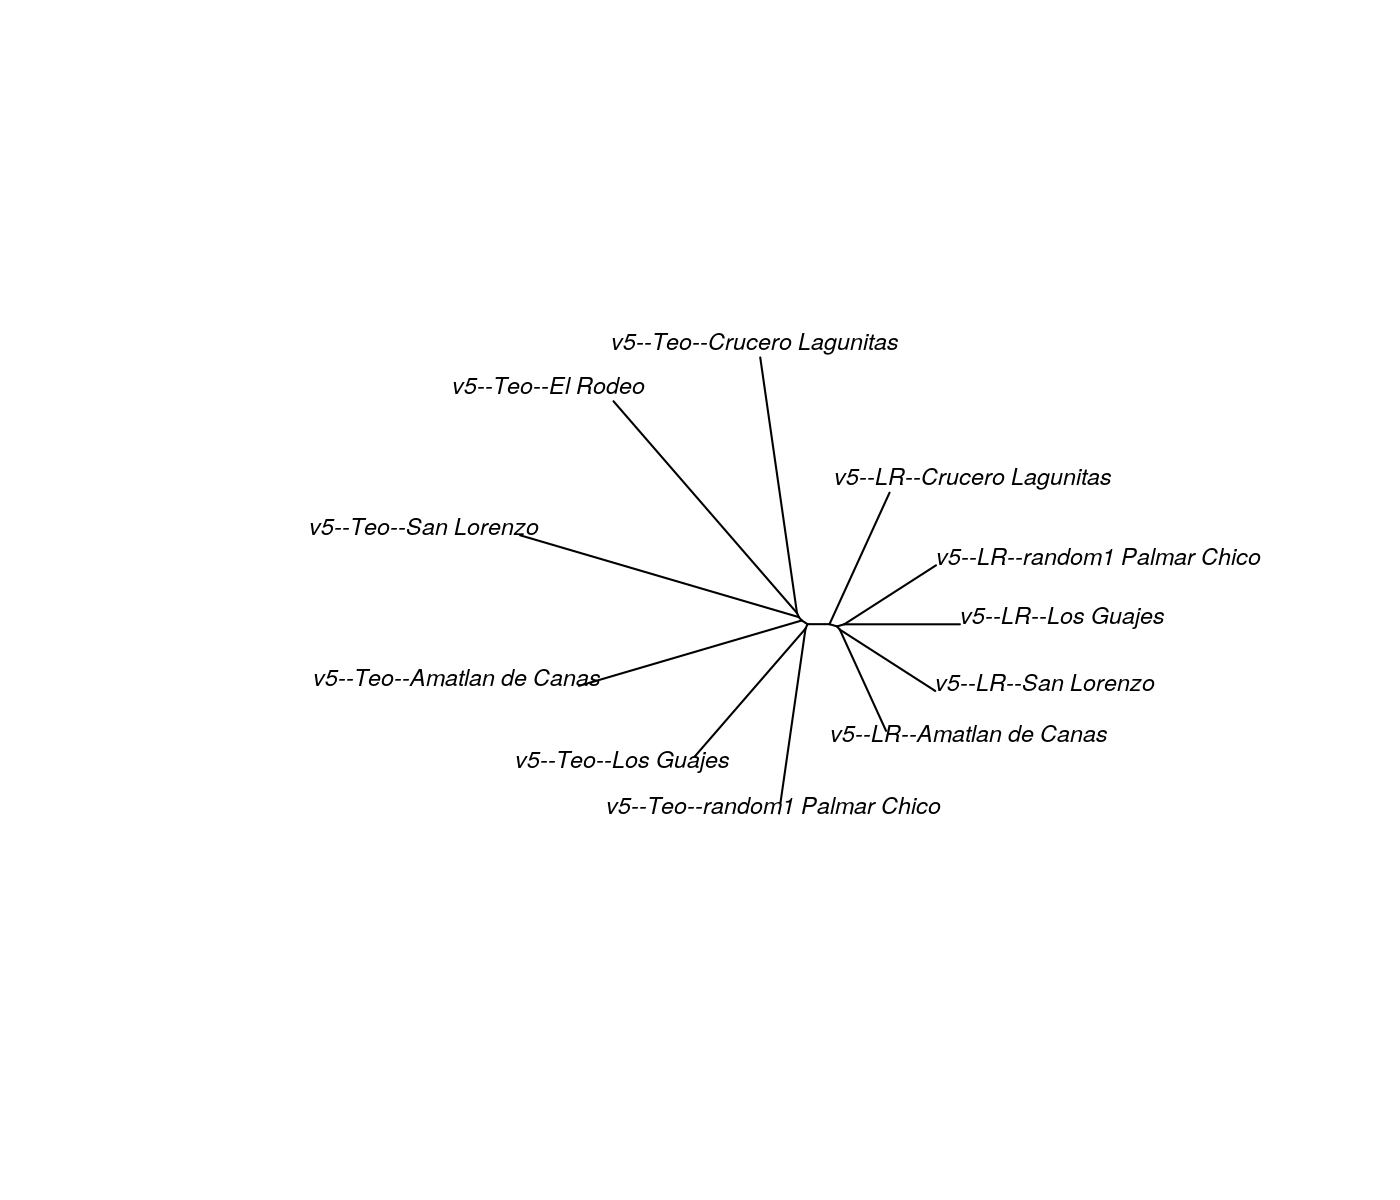

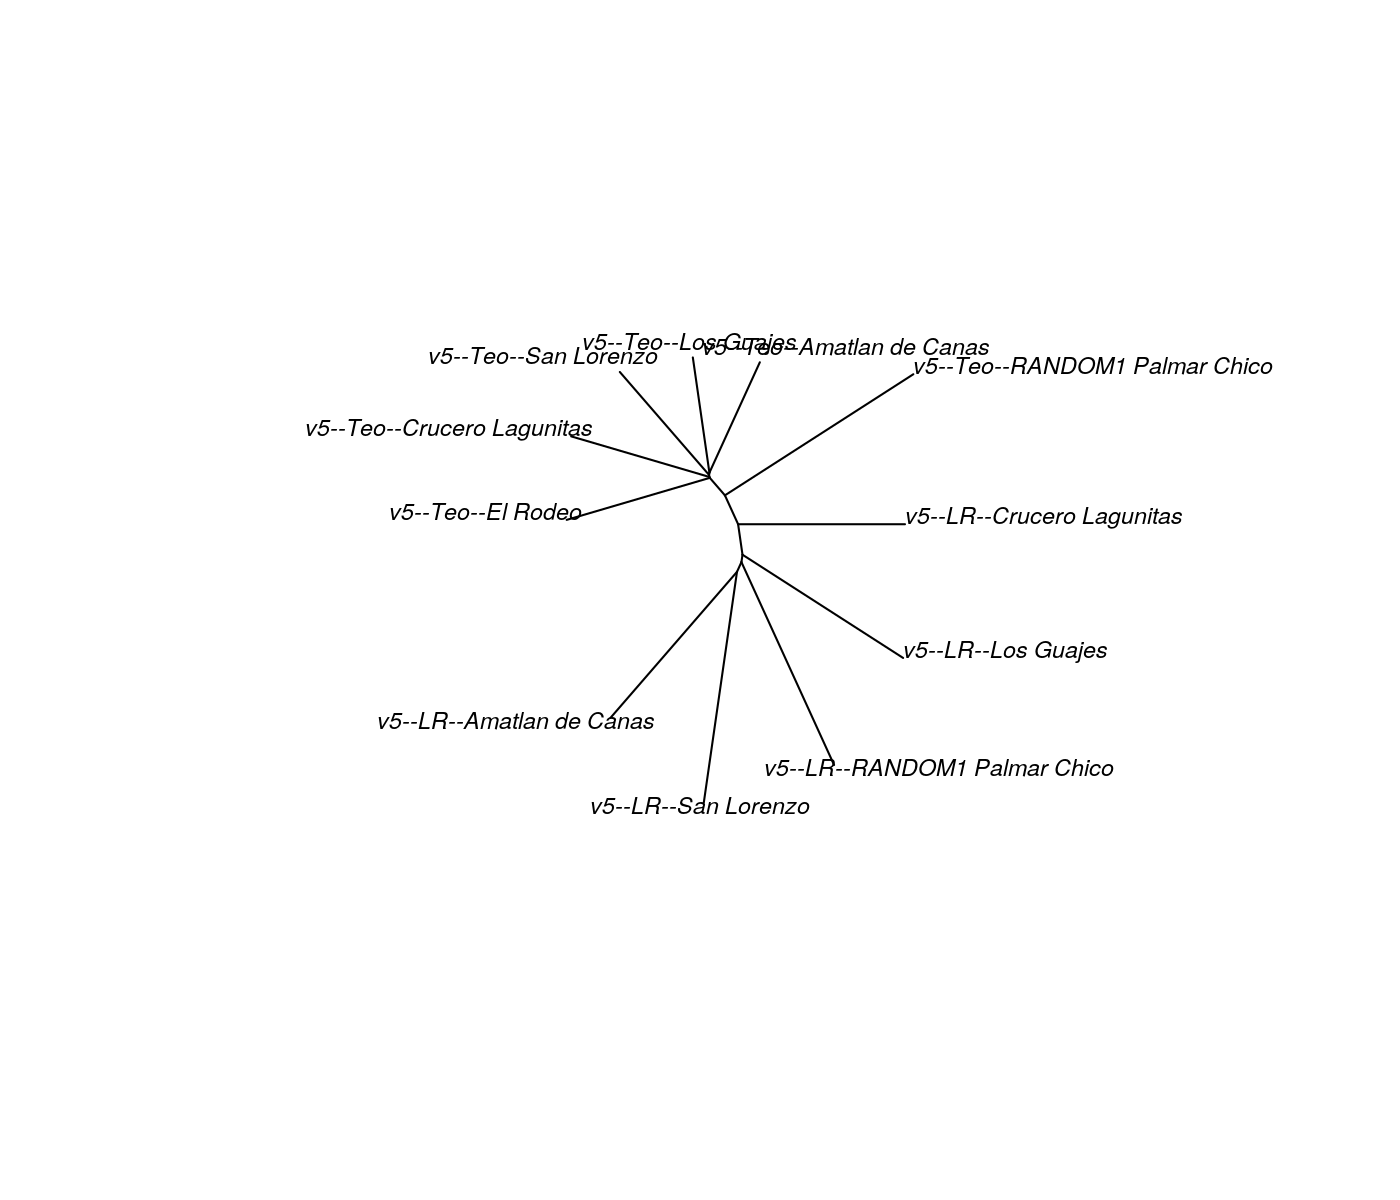

$z.stat
[1] 30687.02

$p
[1] 0.037

$alternative
[1] "two.sided"


	Pearson's product-moment correlation

data:  as.matrix(neut_mat) and as.matrix(sweep_mat)
t = 6.5634, df = 119, p-value = 1.439e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3712069 0.6355549
sample estimates:
      cor 
0.5155439 


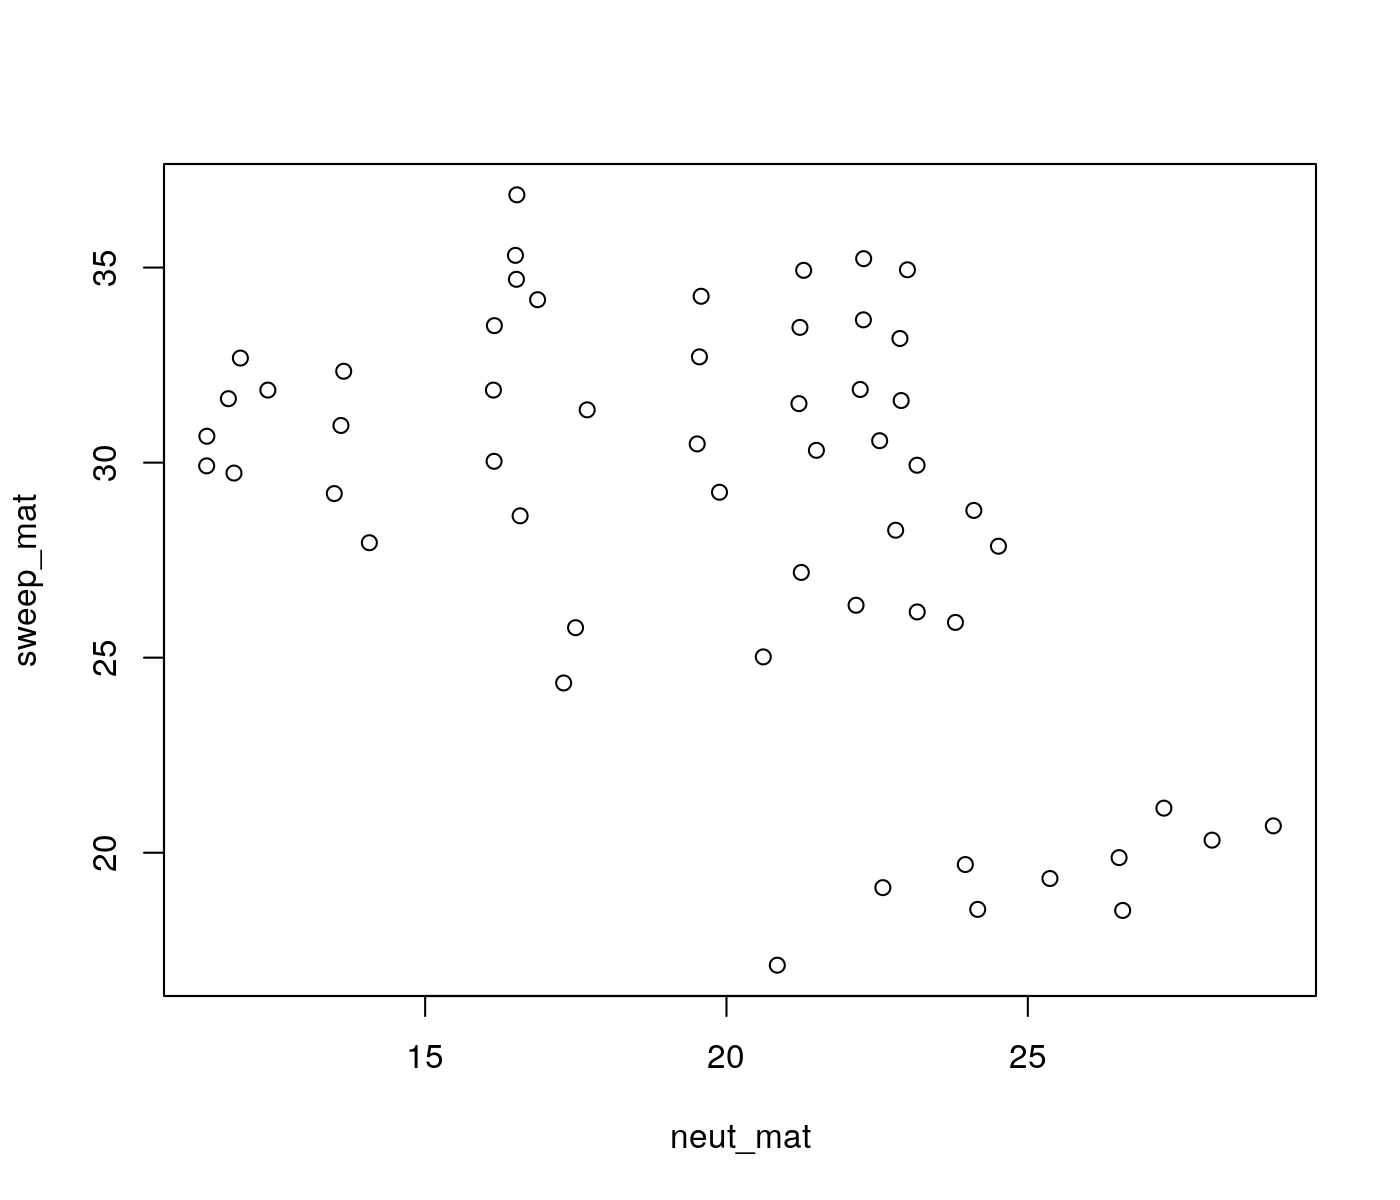

In [203]:
FREQ_POPS = c(
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
)

MIN_FREQ <- 1/20

neutral_freqs <- vroom::vroom(file = "../data/rdmc/v5--neutral_freqs.txt",   
    delim = "\t",
    col_names = FREQ_POPS) %>%
    mutate(varz = apply(dplyr::select(., -c(chrom, start, end)), 1, max)) %>% 
    filter(varz >= MIN_FREQ) %>%
    sample_n(50000) %>% 
    dplyr::select(-varz) 


neut_mat <- neutral_freqs %>% 
    dplyr::select(-c(chrom, start, end)) %>% 
    t() %>% 
    dist()


plot.phylo(nj(neut_mat), type = "unrooted", cex = 0.7)


tree_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--RANDOM1_Palmar_Chico", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--RANDOM1_Palmar_Chico", 
    "v5--Teo--San_Lorenzo"
)

share_aln <- 
map_dfc(1:nrow(share_df), function(c){
    tibble(as.numeric(map_lgl(tree_pops, ~grepl(.x, share_df$populations[c])))) %>% 
    set_colnames(paste0("s", c))
})

rownames(share_aln) <- tree_pops

sweep_mat <- dist(share_aln)
plot.phylo(nj(sweep_mat), type = "unrooted", cex = 0.7)


plot(neut_mat, sweep_mat)
mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat))

cor.test(as.matrix(neut_mat), as.matrix(sweep_mat))


In [103]:
pair_df <- 

c("both", "Teosinte", "Landraces") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(share_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(share_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))


head(pair_df)

pop,count_pop1,count_pop2
<chr>,<int>,<int>
v5--LR--Amatlan_de_Canas,863,863
v5--LR--Crucero_Lagunitas,518,518
v5--LR--Los_Guajes,769,769
v5--LR--RANDOM1_Palmar_Chico,1000,1000
v5--LR--RANDOM2_Palmar_Chico,879,879
v5--LR--random,1244,1244


pop1,pop2,share_count,type
<chr>,<chr>,<int>,<chr>


pop1,pop2,share_count,type
<chr>,<chr>,<int>,<chr>
v5--LR--Amatlan_de_Canas,v5--LR--San_Lorenzo,306,Landraces
v5--LR--RANDOM1_Palmar_Chico,v5--LR--RANDOM2_Palmar_Chico,292,Landraces
v5--LR--RANDOM1_Palmar_Chico,v5--LR--San_Lorenzo,290,Landraces
v5--LR--random,v5--LR--San_Lorenzo,263,Landraces
v5--LR--Los_Guajes,v5--LR--RANDOM1_Palmar_Chico,261,Landraces
v5--LR--RANDOM2_Palmar_Chico,v5--LR--San_Lorenzo,253,Landraces


In [11]:
full_pair_df <- pair_df %>% 
    left_join(., dplyr::select(pop_count_df, -count_pop2), by = c("pop1" = "pop")) %>% 
    left_join(., dplyr::select(pop_count_df, -count_pop1), by = c("pop2" = "pop")) %>% 
    mutate(
        populations = paste(pop1, pop2, sep = ","),
        pair_type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan")
    ) %>% 
    separate(pop1, c("ref", "ssp1", "pop1"), "--") %>% 
    separate(pop2, c("ref", "ssp2", "pop2"), "--") %>% 
    mutate(geography = case_when(
        ssp1 != ssp2 & pop1 == pop2 ~ "sympatric",
        TRUE ~ "allopatric"
    )) %>% 
    full_join(., sweep_counts_df, by = "type") %>% 
    arrange(desc(share_count))

false_positive_df <- full_pair_df %>% 
    filter(ssp1 == ssp2, 
           pop1 %in% c("RANDOM1_Palmar_Chico", "RANDOM2_Palmar_Chico"),
           pop2 %in% c("RANDOM1_Palmar_Chico", "RANDOM2_Palmar_Chico")) %>% 
    mutate(false_positive = (share_count/count_pop1 + share_count/count_pop2)/2)

false_positive_df$false_positive

full_pair_df %>% 
    filter(ssp1 == "Teo", ssp2 == "Teo", type == "Landraces")

[1] 0.3042038 0.2469051 0.3773885 0.1715402

ssp1,pop1,share_count,ref,ssp2,pop2,type,count_pop1,count_pop2,populations,pair_type,geography,total_sweeps
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>


In [12]:
phyper(q = 529 - 1, m = 901, n = 2758-901, k = 1027, lower.tail = FALSE, log.p = TRUE)

[1] -133.3774

In [13]:
false_positive <- mean(false_positive_df$false_positive)

pair_test_df <- 
full_pair_df %>%
    rowwise() %>% 
    mutate(
        p = -phyper(q = as.integer(share_count*false_positive)-1,
           m = as.integer(min(count_pop1, count_pop2)*false_positive),
           n = as.integer(total_sweeps*false_positive - min(count_pop1, count_pop2)*false_positive),
           k = as.integer(max(count_pop1, count_pop2)*false_positive), lower.tail = FALSE, log.p = TRUE),
        p_lower = -phyper(q = as.integer(share_count*false_positive)-1,
           m = as.integer(min(count_pop1, count_pop2)*false_positive),
           n = as.integer(total_sweeps*false_positive - min(count_pop1, count_pop2)*false_positive),
           k = as.integer(max(count_pop1, count_pop2)*false_positive), lower.tail = TRUE, log.p = TRUE),
        age = case_when(type == "both" ~ "old", TRUE ~ "young")
    ) %>% 
    mutate(pop1 = str_remove_all(pop1, "RANDOM1_"),
           pop2 = str_remove_all(pop2, "RANDOM1_")) %>% 
    left_join(., color_df, by = c("pop1" = "pop")) %>% 
    rename(color_pop1 = color) %>% 
    left_join(., color_df, by = c("pop2" = "pop")) %>% 
    rename(color_pop2 = color) 


pair_test_df

ssp1,pop1,share_count,ref,ssp2,pop2,type,count_pop1,count_pop2,populations,pair_type,geography,total_sweeps,p,p_lower,age,color_pop1,color_pop2
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
LR,Amatlan_de_Canas,306,v5,LR,San_Lorenzo,Landraces,890,1136,"v5--LR--Amatlan_de_Canas,v5--LR--San_Lorenzo",Landraces,allopatric,2758,3.370200e-03,5.694468e+00,young,cornflowerblue,purple
LR,Palmar_Chico,292,v5,LR,RANDOM2_Palmar_Chico,Landraces,1027,901,"v5--LR--RANDOM1_Palmar_Chico,v5--LR--RANDOM2_Palmar_Chico",Landraces,allopatric,2758,2.220211e-02,3.818649e+00,young,violetred,NA
LR,Palmar_Chico,290,v5,LR,San_Lorenzo,Landraces,1027,1136,"v5--LR--RANDOM1_Palmar_Chico,v5--LR--San_Lorenzo",Landraces,allopatric,2758,3.192369e-09,1.956250e+01,young,violetred,purple
LR,random,263,v5,LR,San_Lorenzo,Landraces,1340,1136,"v5--LR--random,v5--LR--San_Lorenzo",Landraces,allopatric,2758,9.081792e-34,7.608162e+01,young,grey,purple
LR,Los_Guajes,261,v5,LR,Palmar_Chico,Landraces,784,1027,"v5--LR--Los_Guajes,v5--LR--RANDOM1_Palmar_Chico",Landraces,allopatric,2758,5.581990e-02,2.913405e+00,young,mediumaquamarine,violetred
LR,RANDOM2_Palmar_Chico,253,v5,LR,San_Lorenzo,Landraces,901,1136,"v5--LR--RANDOM2_Palmar_Chico,v5--LR--San_Lorenzo",Landraces,allopatric,2758,5.272481e-08,1.675818e+01,young,NA,purple
LR,Los_Guajes,251,v5,LR,San_Lorenzo,Landraces,784,1136,"v5--LR--Los_Guajes,v5--LR--San_Lorenzo",Landraces,allopatric,2758,4.468348e-04,7.713545e+00,young,mediumaquamarine,purple
LR,Amatlan_de_Canas,240,v5,LR,Palmar_Chico,Landraces,890,1027,"v5--LR--Amatlan_de_Canas,v5--LR--RANDOM1_Palmar_Chico",Landraces,allopatric,2758,1.745707e-05,1.095577e+01,young,cornflowerblue,violetred
LR,Palmar_Chico,240,v5,LR,random,Landraces,1027,1340,"v5--LR--RANDOM1_Palmar_Chico,v5--LR--random",Landraces,allopatric,2758,3.216906e-28,6.330396e+01,young,violetred,grey


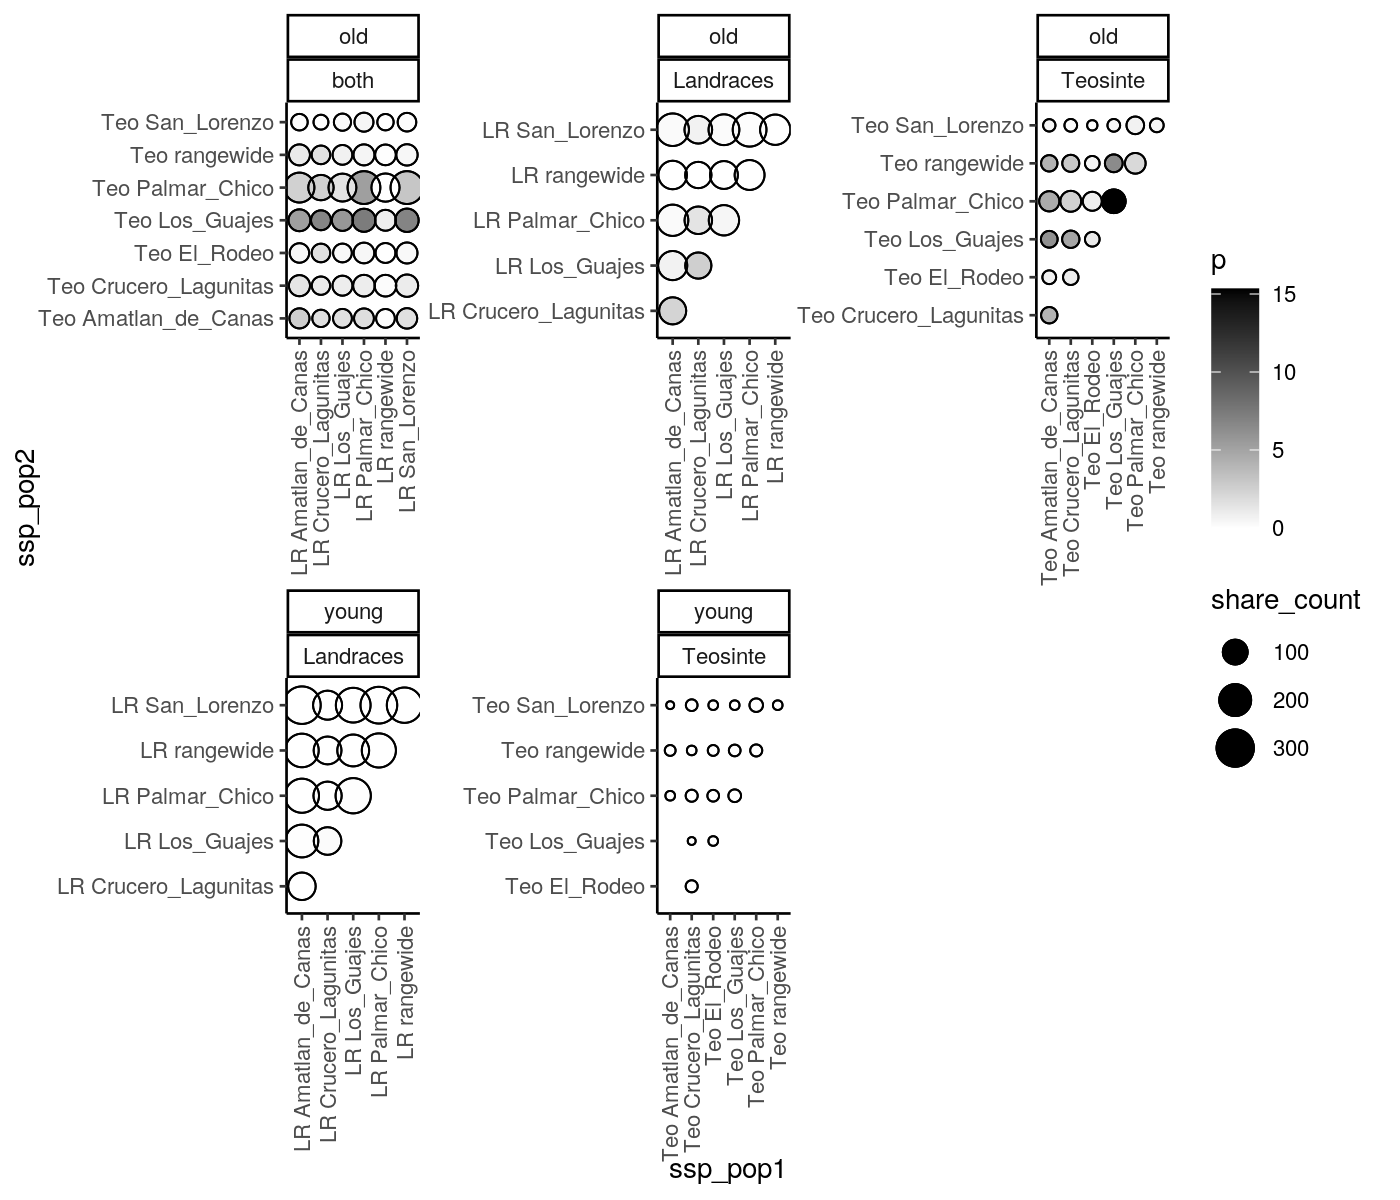

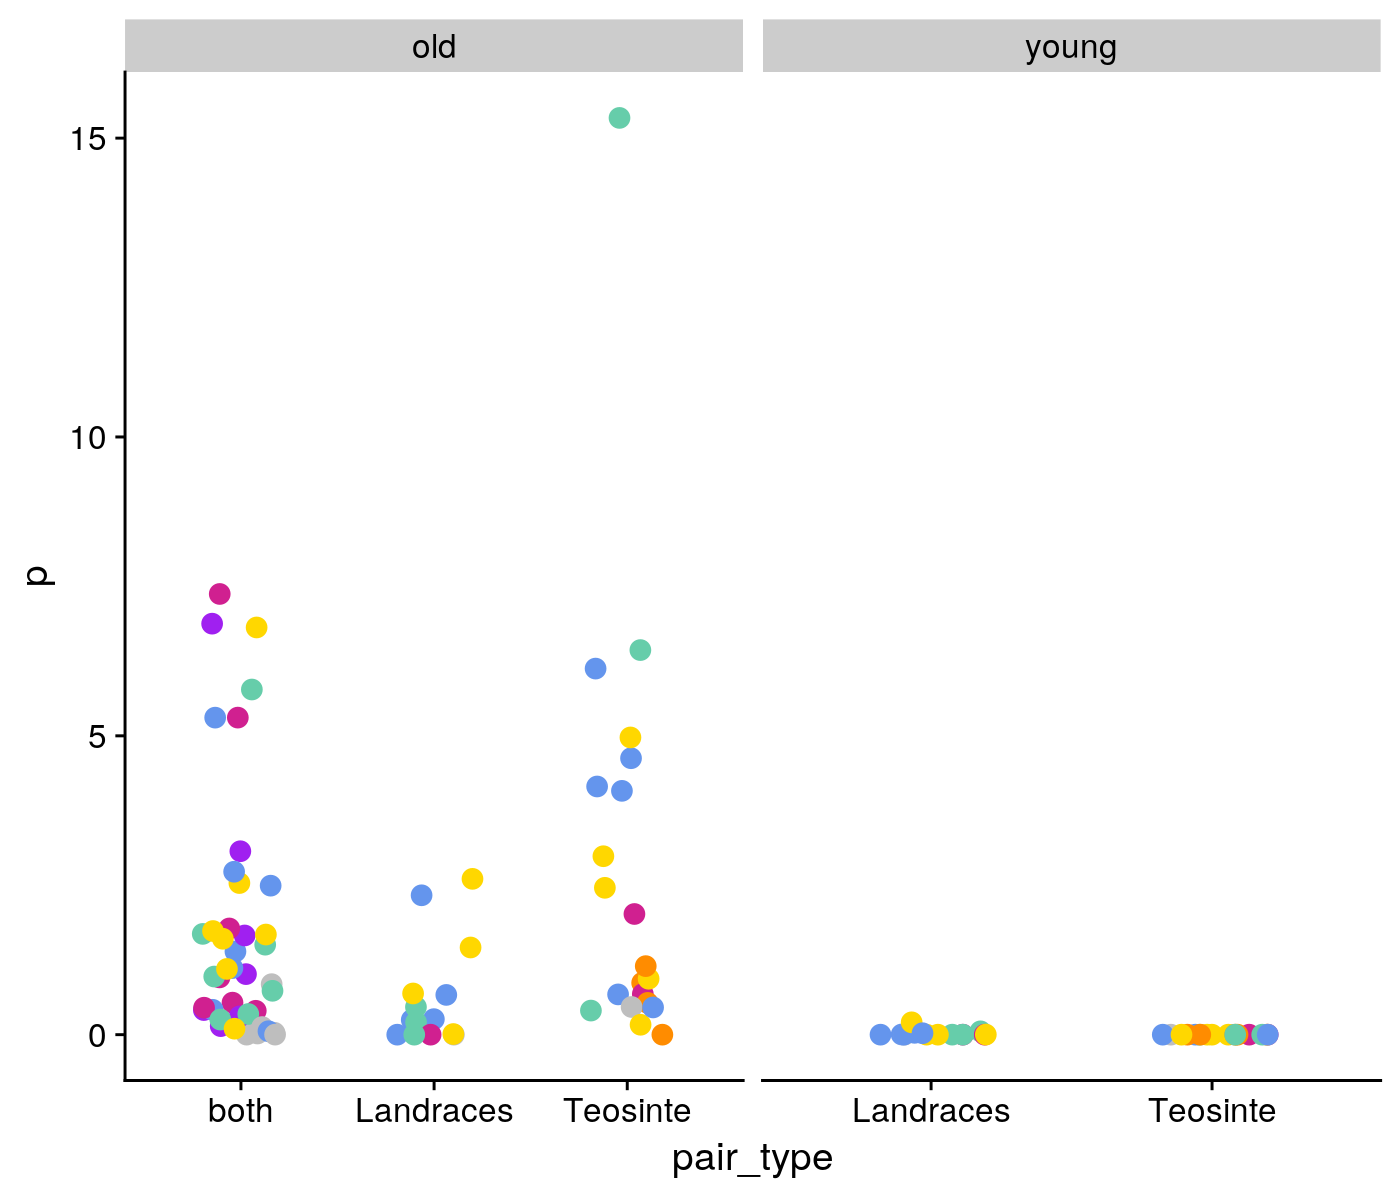

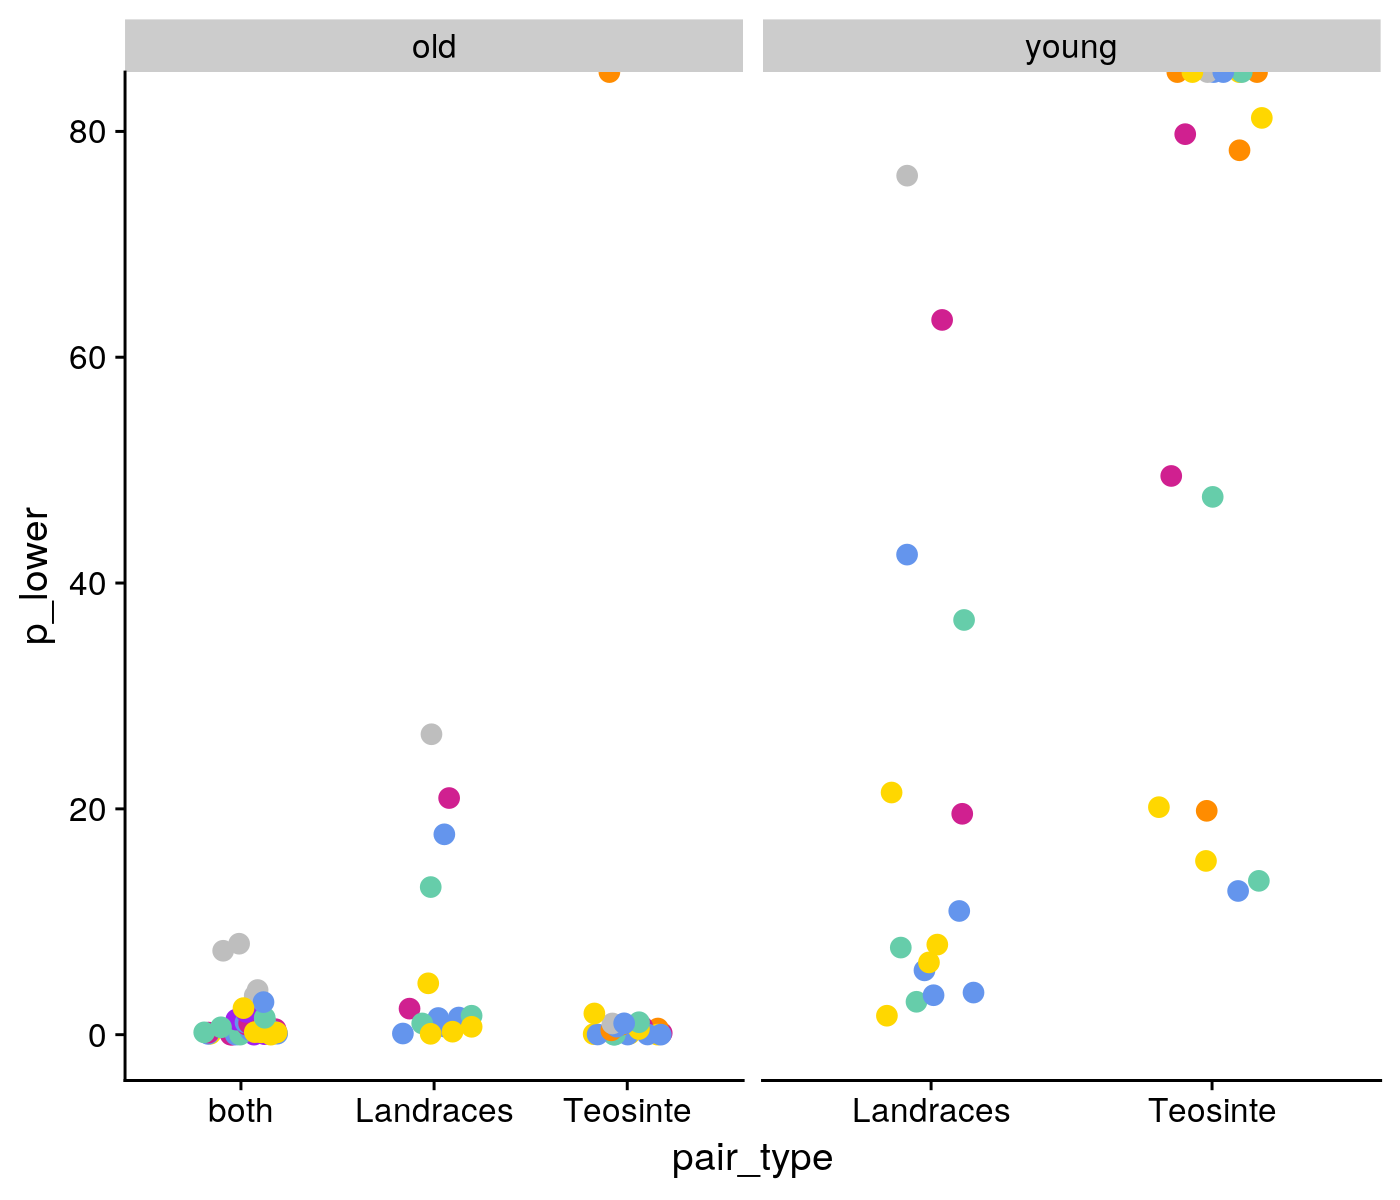

In [14]:
plot_pair_df <- 
pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    mutate(pop1 = str_replace_all(pop1, "random", "rangewide"),
           pop2 = str_replace_all(pop2, "random", "rangewide"),
           ssp_pop1 = paste0(ssp1 ," ", pop1),
           ssp_pop2 = paste0(ssp2 ," ", pop2))  %>%  
    ungroup() %>% 
    mutate(pop1_idx = as.numeric(as.factor(pop1))) %>%
    mutate(pop2_idx = as.numeric(as.factor(pop2)))


plot_pair_df %>% 
    ggplot(aes(ssp_pop1, ssp_pop2, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(ssp_pop1, ssp_pop2, size = share_count), shape = 1, inherit.aes = F) +
    geom_point(aes(ssp_pop1, ssp_pop2, size = share_count), shape = 1, inherit.aes = F) +
    facet_wrap(~age+pair_type, scales = "free") +
    scale_colour_gradient(low = "white", high = "black") +
    theme_classic(base_size = 10) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 



p_top5 <- pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    filter(p > 5)
    #group_by(type) %>% 
    #arrange(p_lower) %>% 
    #slice(1:6) %>% 
    #filter(type !="Teosinte")

p_low_top5 <- pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    filter(p_lower > 5)
    #group_by(type) %>% 
    #arrange(desc(p_lower)) %>% 
    #slice(1:6) 


pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    ggplot(aes(pair_type, p)) +
    #geom_jitter(aes(colour = color_pop1, bg = color_pop2), stroke = 2, shape = 21, width = 0.2, height = 0, size = 3) +
    geom_jitter(aes(colour = color_pop1), width = 0.2, height = 0, size = 3) +
    facet_wrap(~age, scales = "free_x") +
    scale_color_identity()


pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    ggplot(aes(pair_type, p_lower)) +
    #geom_jitter(aes(colour = pop1, bg = pop2), stroke = 2, shape = 21, width = 0.2, height = 0, size = 3) +
    geom_jitter(aes(colour = color_pop1), width = 0.2, height = 0, size = 3) +    
    facet_wrap(~age, scales = "free_x") +
    scale_color_identity()


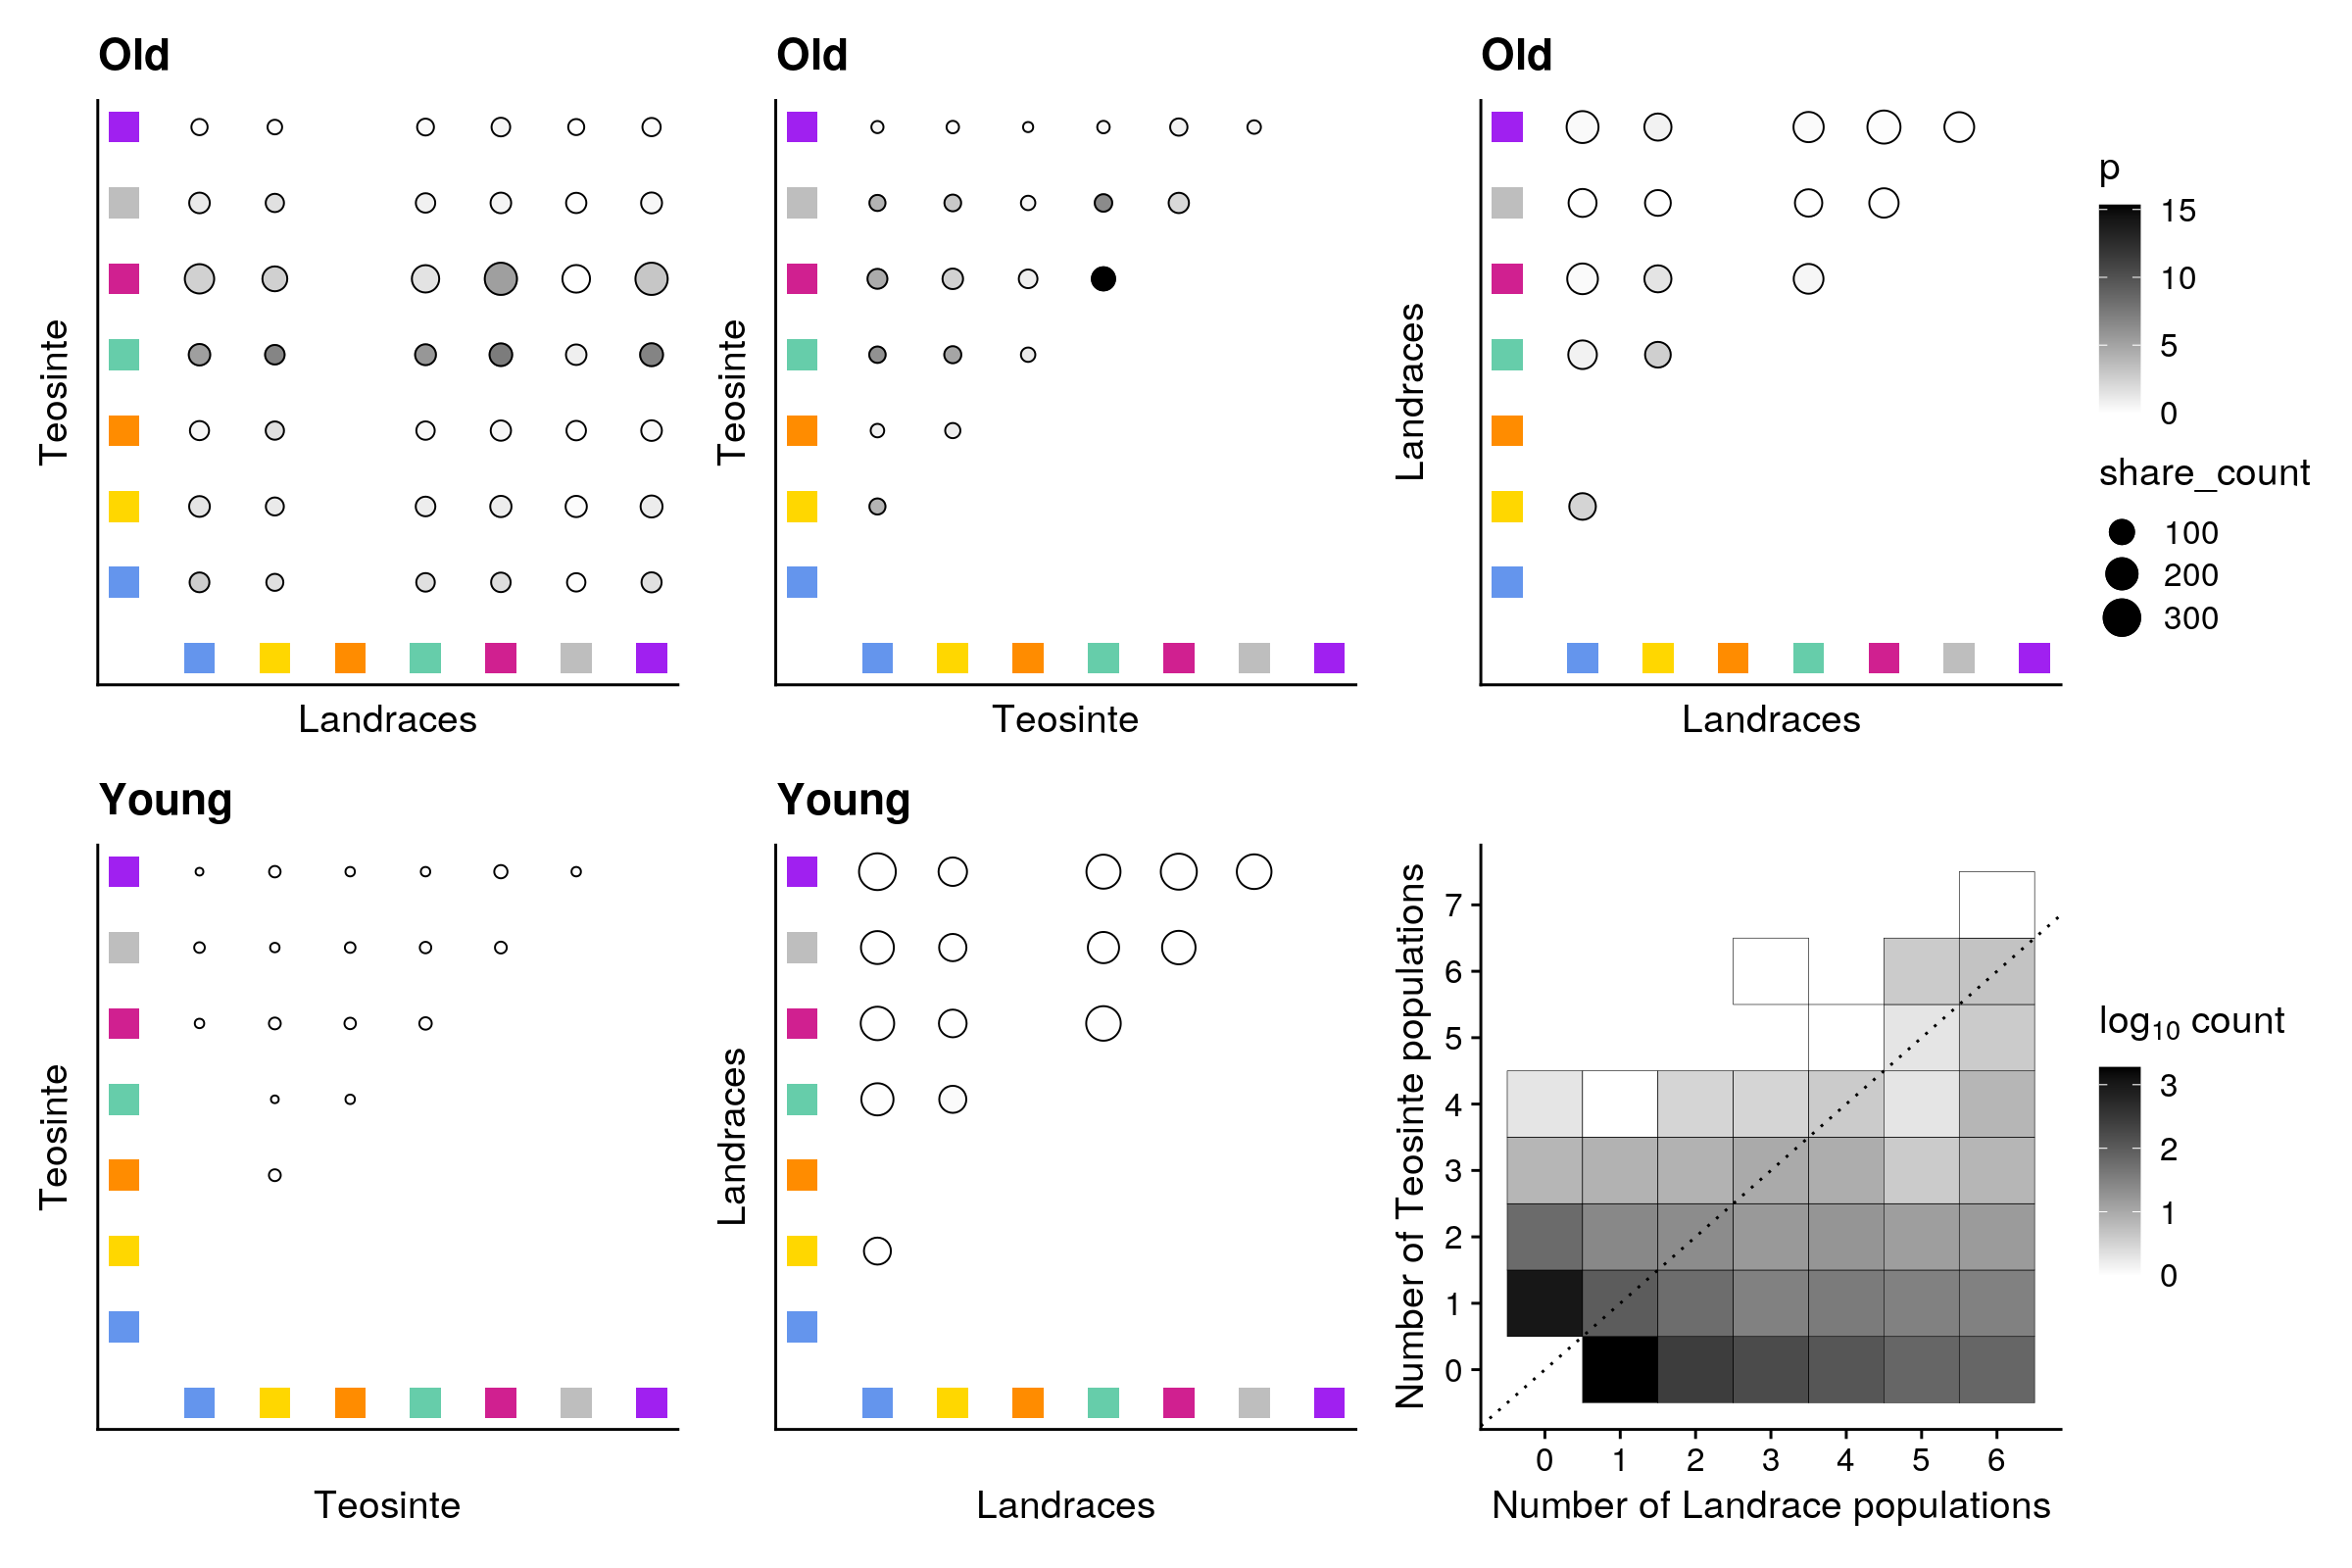

In [15]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 200)

edge_df <- 
    plot_pair_df %>% 
    dplyr::select(color_pop1, color_pop2, pop1_idx, pop2_idx) %>% 
    mutate(zeros = 0)

p_rng <- range(plot_pair_df$p)
size_rng <- range(plot_pair_df$share_count)

old_both <- plot_pair_df %>% 
    filter(age == "old", pair_type == "both") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Landraces") +
    ylab("Teosinte") +
    scale_size(limits = size_rng) 


old_teo <- plot_pair_df %>% 
    filter(age == "old", pair_type == "Teosinte") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Teosinte") +
    ylab("Teosinte") +
    scale_size(limits = size_rng) 

old_lr <- plot_pair_df %>% 
    filter(age == "old", pair_type == "Landraces") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Landraces") +
    ylab("Landraces") +
    scale_size(limits = size_rng) 



young_teo <- plot_pair_df %>% 
    filter(age == "young", pair_type == "Teosinte") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Teosinte") +
    ylab("Teosinte") +
    scale_size(limits = size_rng) 


young_lr <- plot_pair_df %>% 
    filter(age == "young", pair_type == "Landraces") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Landraces") +
    ylab("Landraces") +
    scale_size(limits = size_rng) 


(old_both +  ggtitle("Old") + theme(legend.position = "n")) +
(old_teo +  ggtitle("Old") + theme(legend.position = "n")) +
(old_lr +  ggtitle("Old")+ theme()) +
(young_teo +  ggtitle("Young") + theme(legend.position = "n")) +
(young_lr +  ggtitle("Young") + theme(legend.position = "n")) +
shareplot +
plot_layout(ncol = 3)


In [16]:
plot_pair_df %>% 
    #filter(age == "young", pair_type == "Teosinte") %>%
    dplyr::select(ssp1, pop1, ssp2, pop2, share_count, type, pair_type) %>% 
    sample_n(100)

ssp1,pop1,ssp2,pop2,share_count,type,pair_type
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
Teo,Crucero_Lagunitas,Teo,Los_Guajes,1,Teosinte,Teosinte
LR,Palmar_Chico,Teo,Amatlan_de_Canas,51,both,both
Teo,Los_Guajes,Teo,Palmar_Chico,87,both,Teosinte
Teo,Palmar_Chico,Teo,San_Lorenzo,34,both,Teosinte
LR,Amatlan_de_Canas,LR,rangewide,230,Landraces,Landraces
Teo,El_Rodeo,Teo,rangewide,4,Teosinte,Teosinte
Teo,Los_Guajes,Teo,San_Lorenzo,2,Teosinte,Teosinte
LR,Crucero_Lagunitas,LR,Palmar_Chico,135,both,Landraces
LR,Los_Guajes,LR,rangewide,200,Landraces,Landraces



Attaching package: ‘tidygraph’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:stats’:

    filter




# A tbl_graph: 13 nodes and 111 edges
#
# A directed acyclic multigraph with 1 component
#
# Node Data: 13 x 4 (active)
  name                  degree ssp   pop              
  <chr>                  <dbl> <chr> <chr>            
1 LR--Amatlan_de_Canas       0 LR    Amatlan_de_Canas 
2 LR--Crucero_Lagunitas      2 LR    Crucero_Lagunitas
3 LR--Los_Guajes             4 LR    Los_Guajes       
4 LR--Palmar_Chico           6 LR    Palmar_Chico     
5 LR--rangewide              8 LR    rangewide        
6 LR--San_Lorenzo           10 LR    San_Lorenzo      
# … with 7 more rows
#
# Edge Data: 111 x 3
   from    to share_count
  <int> <int>       <int>
1     1     2         135
2     1     2         129
3     1     3         216
# … with 108 more rows

Using `sugiyama` as default layout



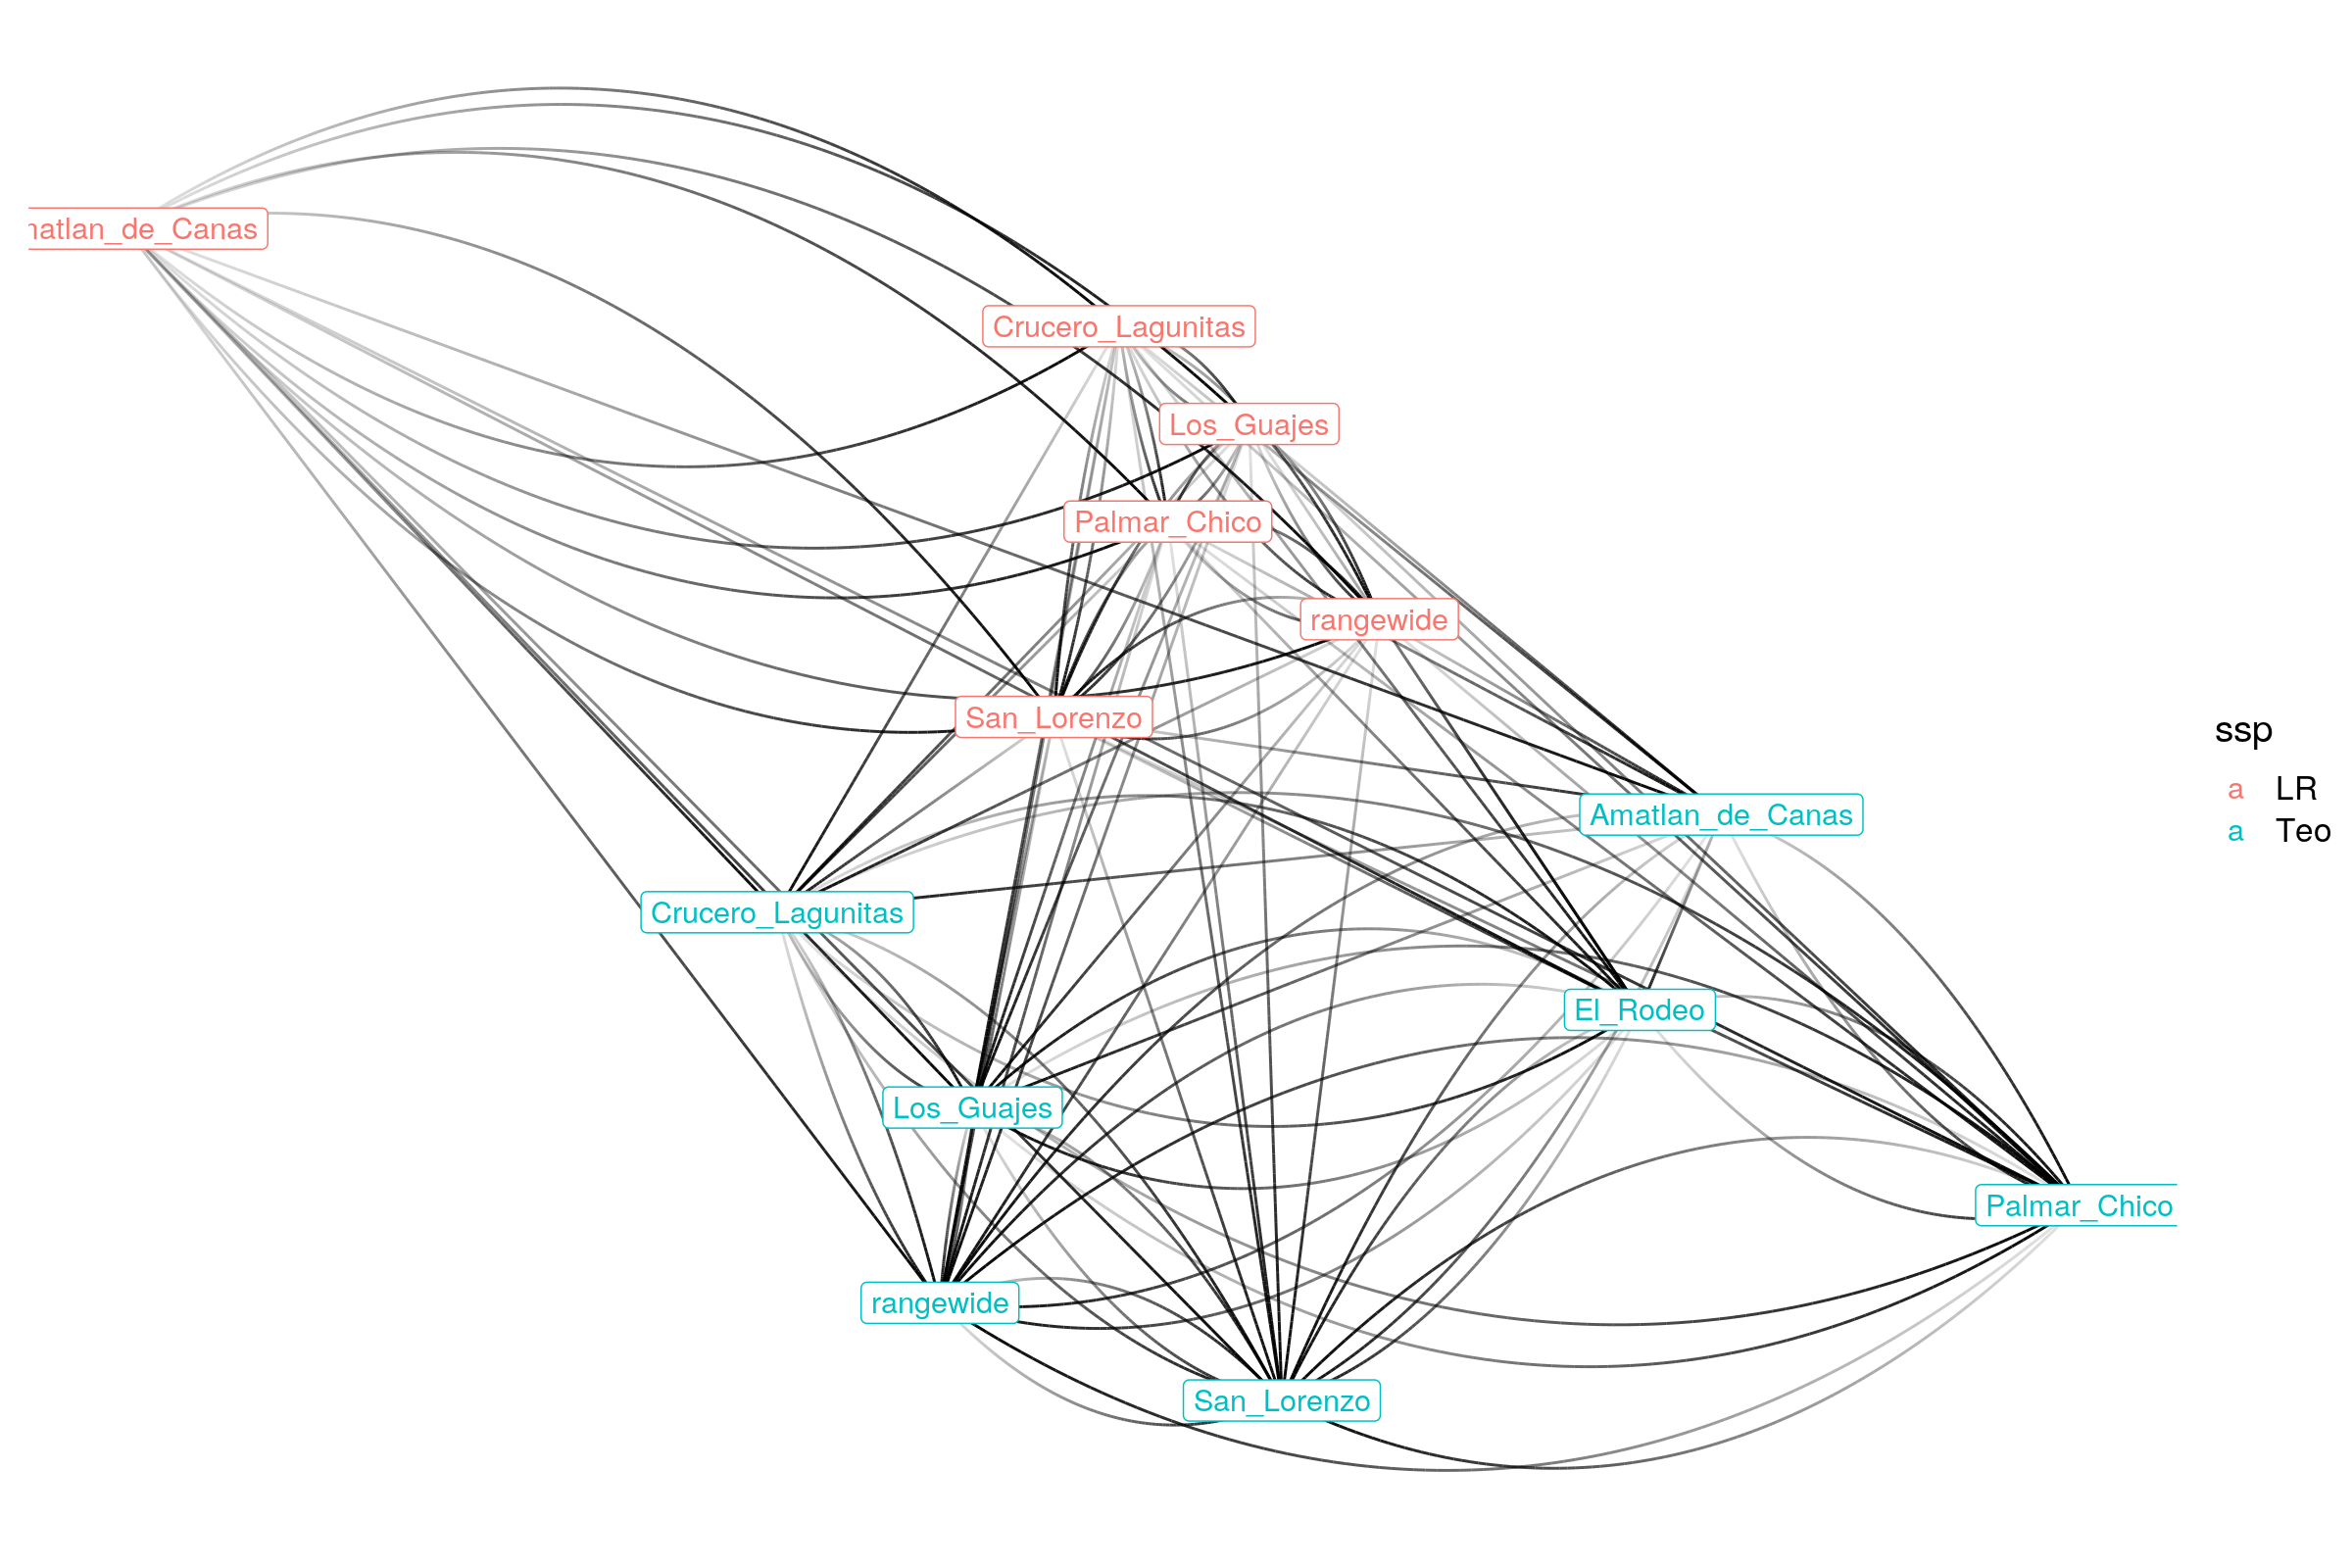

In [17]:
library(tidygraph)

network_df <- plot_pair_df %>% 
    #filter(age == "young", pair_type == "Landraces") %>%
    mutate(ssp_pop1 = paste0(ssp1, "--", pop1),
          ssp_pop2 = paste0(ssp2, "--", pop2)) %>% 
    dplyr::select(ssp_pop1, ssp_pop2, share_count)  %>% 
    arrange(ssp_pop1, ssp_pop2) %>% 
    as_tbl_graph() %>%
    mutate(degree = centrality_degree(mode = 'in'),
          ssp = str_split(name, "--", simplify = TRUE)[,1],
          pop = str_split(name, "--", simplify = TRUE)[,2]
          )

network_df
# plot using ggraph
ggraph(network_df) +
    geom_edge_fan(aes(alpha = stat(index)), show.legend = FALSE) +
    #geom_node_point(aes(size = degree, colour = ssp)) +
    geom_node_label(aes(label = pop, colour = ssp))